## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [347]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_camera_calibration_points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    return (objpoints, imgpoints)





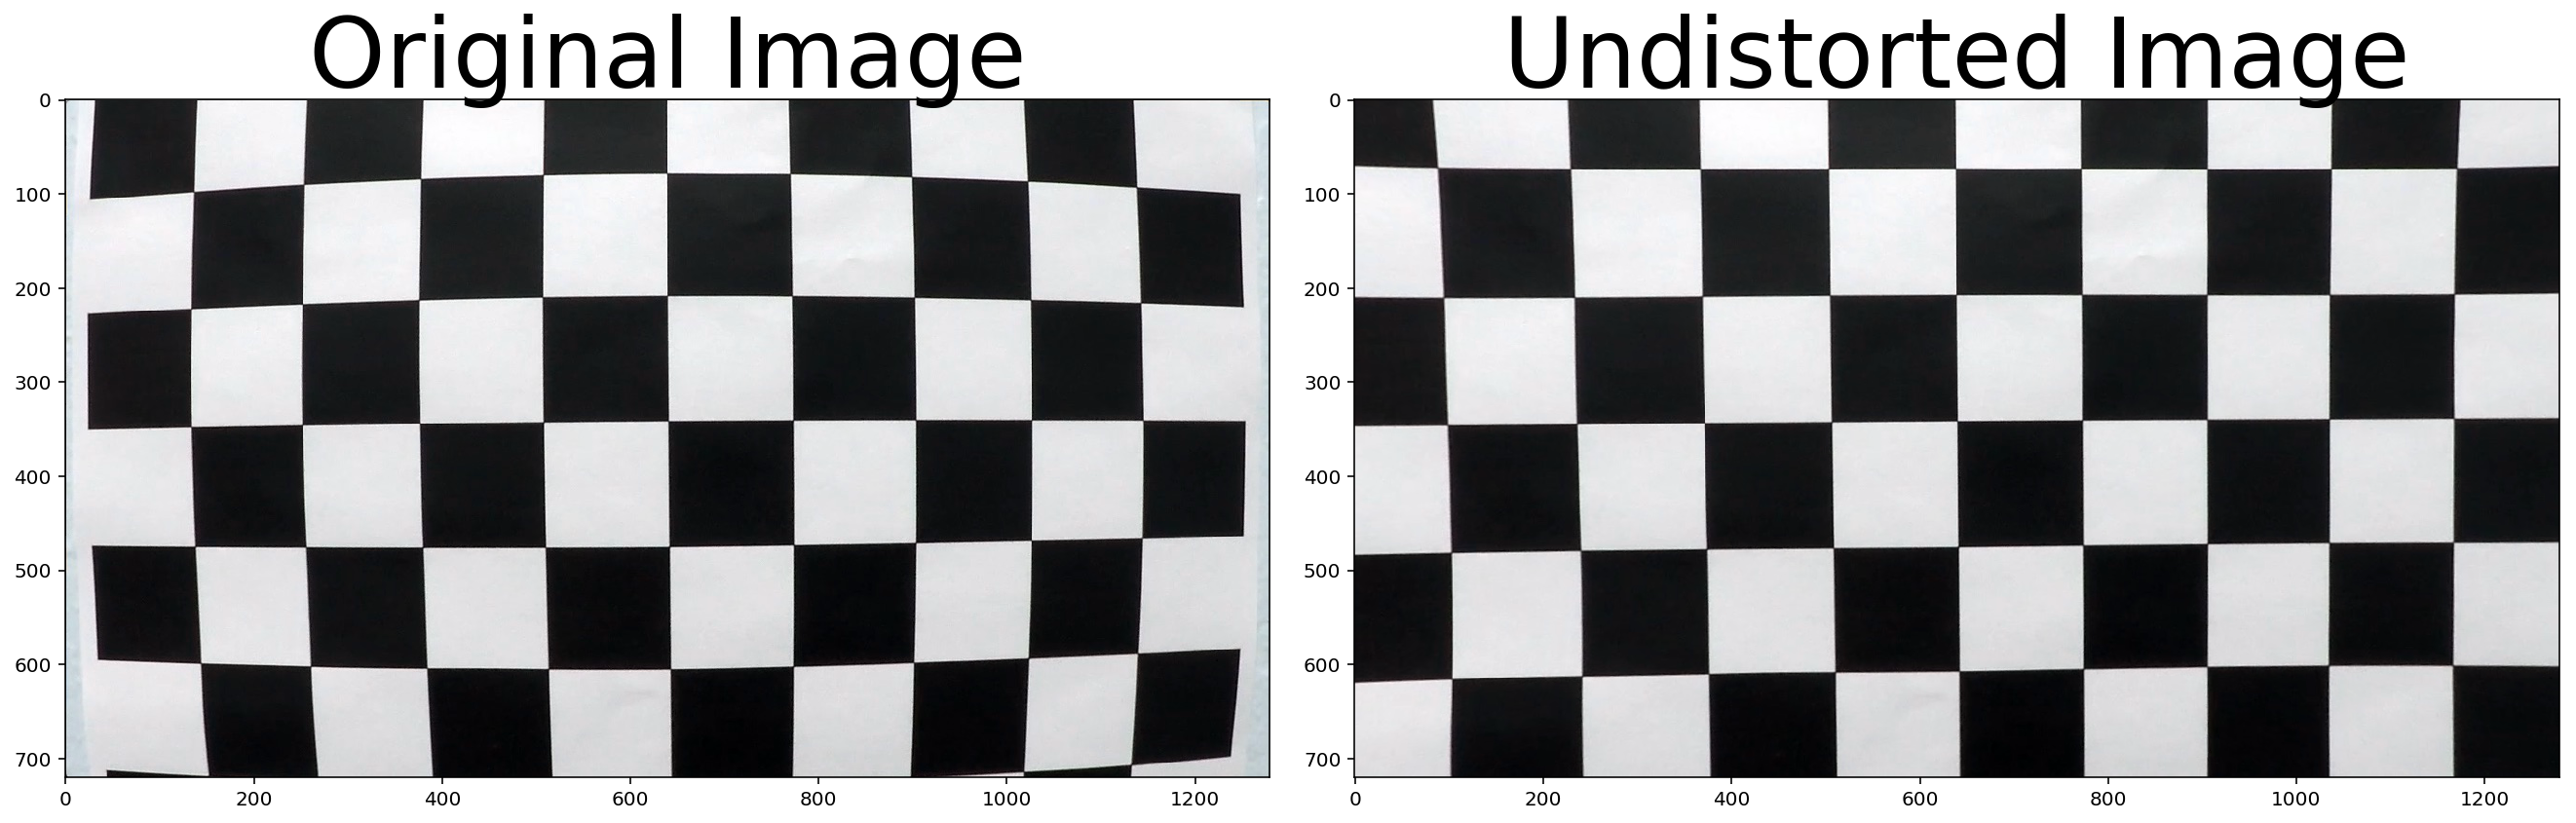

In [348]:
##Undistorting image
img= cv2.imread('../camera_cal/calibration1.jpg')

def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

(objpoints, imgpoints) = get_camera_calibration_points()
undistorted=undistort(img, objpoints, imgpoints)   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

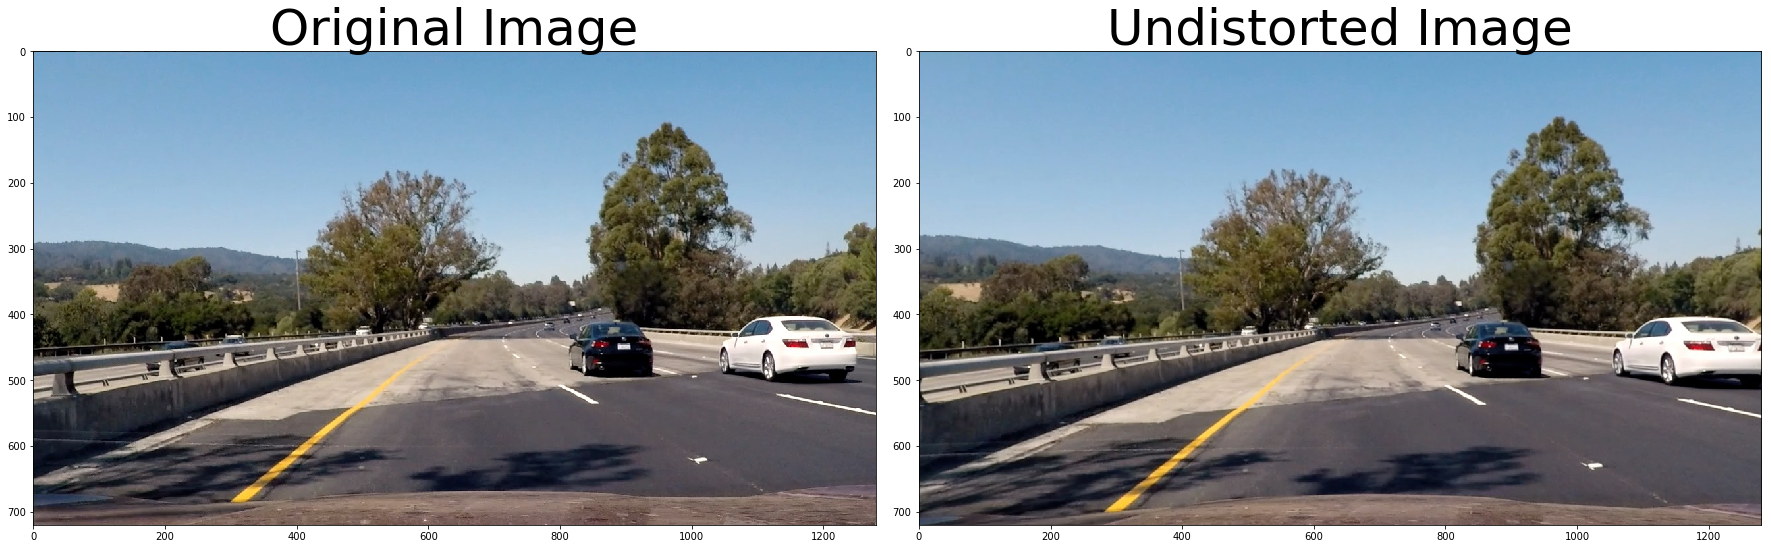

In [498]:
image_name='../test_images/test4.jpg'
img= cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted=undistort(img, objpoints, imgpoints)   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color & gradient filters

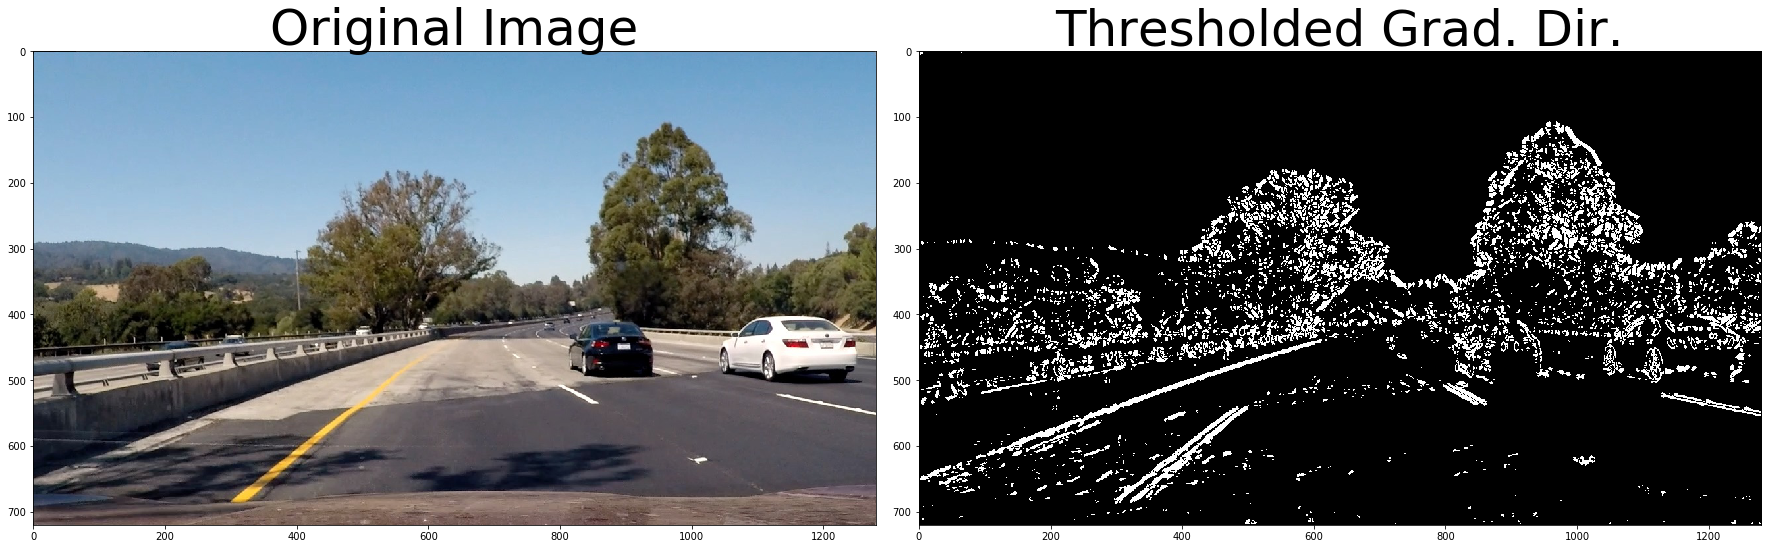

In [483]:
image_name='../test_images/test4.jpg'
#image_name='../test_images/challenge_1.jpg'
#image_name='../test_images/challenge_2.jpg'
image = cv2.imread(image_name) #5
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
## Gradient treshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 240))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1) & (grady == 1)) | (mag_binary == 1)] = 1

dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.9, 1.1))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


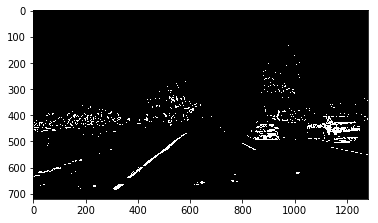

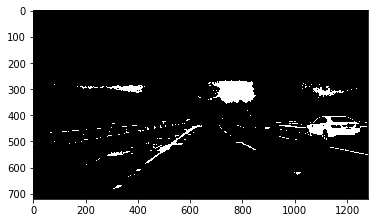

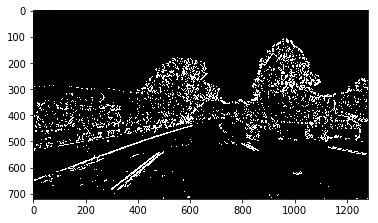

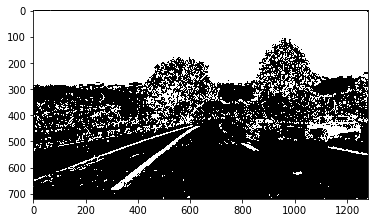

In [487]:
##color thresholds
%matplotlib inline
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def hsv_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    return binary_output

def grey_select(img, thresh=(0, 255)):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(grey)
    binary_output[(grey > thresh[0]) & (grey <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(170, 255))

grey_binary = grey_select(image, thresh=(200, 255))
combined = np.zeros_like(grey_binary)
#combined[((hls_binary == 1) & (grey_binary == 1))] = 1
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1) & (grey_binary == 1))] = 1
plt.imshow(hls_binary, cmap='gray')
plt.show()
plt.imshow(grey_binary, cmap='gray')
plt.show()
plt.imshow(combined, cmap='gray')
plt.show()

def color_and_gradient_filter(img, ksize = 15):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 240))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(100, 255)) #150
    hsv_binary = hsv_select(img, thresh=(50, 255))
    grey_binary = grey_select(img, thresh=(200, 255))
    combined = np.zeros_like(grey_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & ((hls_binary == 1) | (grey_binary == 1) | (hsv_binary == 1)))] = 1

    combined[((gradx == 1) & (grady == 1)) | (((hls_binary == 1)  & (hsv_binary == 1))) ] = 1
    return combined 

plt.imshow(color_and_gradient_filter(image), cmap='gray')
plt.show()
combined= color_and_gradient_filter(image)

## Perspective transform

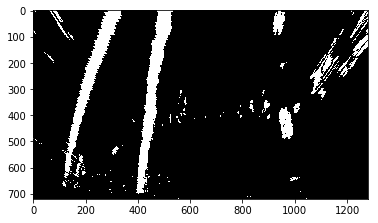

In [490]:
src_points = np.float32([[179, 720], [1140, 720], [740, 460], [550, 460]])
dest_points = np.float32([[350, 720], [977, 720], [977, 0], [350, 0]])

    
def warp(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

warped = warp(combined,src_points, dest_points)
plt.imshow(warped,cmap='gray')
plt.show()

## Find sliding windows

In [491]:
class WindowFinder:
    
    def __init__(self, window_width=50, window_height=80, margin=100, meters_pp_y = 1, meters_pp_x= 1, smooth_factor = 15) :
        self.centers = []
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.meters_pp_y=meters_pp_y
        self.meters_pp_x=meters_pp_x
        self.smooth_factor=smooth_factor

    def find_window_centroids(self, image):
        window_width = self.window_width
        window_height= self.window_height
        margin= self.margin
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        #l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_sum = np.sum(image[int(image.shape[0]/2):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        #r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_sum = np.sum(image[int(image.shape[0]/2):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        self.centers.append(window_centroids)
        return np.average(self.centers[-self.smooth_factor:], axis=0)



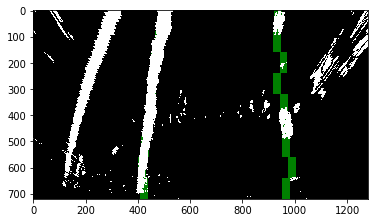

In [492]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

#find centers of the sliding windows
window_width=30
window_height=80
margin=25
meters_pp_y = 10/720
meters_pp_x = 4/380
curve_centers=WindowFinder(window_width=window_width, window_height=window_height, margin=margin,meters_pp_y=meters_pp_y,meters_pp_x=meters_pp_x )
window_centroids= curve_centers.find_window_centroids(image=warped)

#points to draw the windows
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

#points to fit to polinom
leftx= []
rightx= []

# Go through each level and draw the windows 	
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    
    #adding center value for drawing
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])
    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255


# Draw the results
template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

plt.imshow(result)
plt.show()

def get_window_centers(warped_image):
    window_width=30
    window_height=80
    margin=25
    meters_pp_y = 10/720
    meters_pp_x = 4/380
    curve_centers=WindowFinder(window_width=window_width, window_height=window_height, margin=margin,meters_pp_y=meters_pp_y,meters_pp_x=meters_pp_x )
    window_centroids= curve_centers.find_window_centroids(image=warped_image)

    #points to fit to polinom
    leftx= []
    rightx= []

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas

        #adding center value for drawing
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
    return (leftx, rightx, curve_centers)



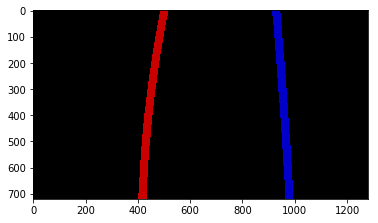

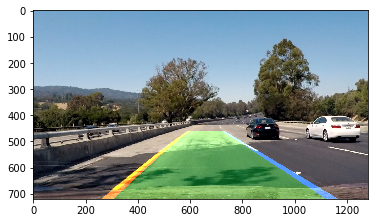

[ 0.00614414 -0.14986014  5.28025645]
81.4684026728


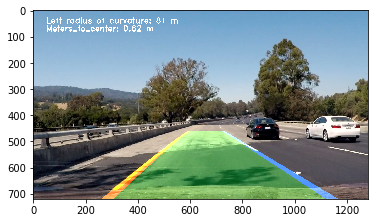

../test_images/test4.jpg


In [493]:
# fit centers of boxes to polinomial of second degree
lane_y =range(0, warped.shape[0])
# box centers
result_y = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)
#left line
left_fit = np.polyfit(result_y, leftx, 2)
left_fitx = np.array(left_fit[0]*lane_y*lane_y + left_fit[1]*lane_y + left_fit[2], np.int32)
#right line
right_fit = np.polyfit(result_y, rightx, 2)
right_fitx = np.array(right_fit[0]*lane_y*lane_y + right_fit[1]*lane_y + right_fit[2], np.int32)

#making line thicker so it gets drawn better
left_line = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)
right_line = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)

lanes = np.zeros_like(image)
inbetween_lanes = np.zeros_like(image)
cv2.fillPoly(lanes, [left_line], color=[200,0,0])
cv2.fillPoly(lanes, [right_line], color=[0,0,200])

#points = np.concatenate((left_line, right_line))
points_left = np.array([np.transpose(np.vstack([left_fitx, lane_y]))])
points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, lane_y])))])
points = np.hstack((points_left, points_right))

cv2.fillPoly(inbetween_lanes, [points], color=(0, 255, 0))
cv2.fillPoly(inbetween_lanes, [left_line], color=(0, 255, 0))
cv2.fillPoly(inbetween_lanes, [right_line], color=(0, 255, 0))

plt.imshow(lanes)
plt.show()

lanes_wraped=unwarp(lanes,src_points, dest_points )
inbetween_lanes_warped = unwarp(inbetween_lanes,src_points, dest_points )

image_with_lines = cv2.addWeighted(image, 1.0, inbetween_lanes_warped, 0.3, 0.0)
image_with_lines_road = cv2.addWeighted(image_with_lines, 1.0, lanes_wraped, 1.0, 0.0)
plt.imshow(image_with_lines_road)
plt.show()

#calculate curvature radius by formular based on polynomial coefficients, take left turn
left_fit_x_r= np.array(left_fitx, np.float32)*curve_centers.meters_pp_x
left_fit_y_r= np.array(lane_y, np.float32)*curve_centers.meters_pp_y
polynomila_fit_real = np.polyfit(left_fit_y_r, left_fit_x_r, 2)
print(polynomila_fit_real)
left_curverad = ((1 + (2*polynomila_fit_real[0]*lane_y[-1]*curve_centers.meters_pp_y + polynomila_fit_real[1])**2)**1.5) / np.absolute(2*polynomila_fit_real[0])

print(left_curverad)
font = cv2.FONT_HERSHEY_DUPLEX
font_color = (255, 255, 255)
font_scale = 1
font_thickness = 2
#Calculating difference from center, assuming tthe middle of the picture should be the center
meters_to_center= ( (left_fitx[-1] + right_fitx[-1]) /2 - warped.shape[1]/2)*curve_centers.meters_pp_x
cv2.putText(image_with_lines_road, 'Left radius of curvature: %d m' % (round(left_curverad)), (50,50), font, font_scale, font_color, font_thickness)
cv2.putText(image_with_lines_road, 'Meters_to_center: %1.2f m' % (meters_to_center), (50,80), font, font_scale, font_color, font_thickness)


plt.imshow(image_with_lines_road)
plt.show()
print(image_name)


    

In [494]:
class Line():
    def __init__(self, n = 2):
        # was the line detected in the last iteration?
        self.detected = False 
        self.n = n
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
    def get_polyfit(self, result_y) :
        if (len(self.recent_xfitted)> (self.n + 1)) :
            self.recent_xfitted.pop(0)
        x_avg = np.mean(self.recent_xfitted, axis=0)
        poly_fit = np.polyfit(result_y, x_avg, 2)
        return poly_fit


In [495]:

def get_final_image(image_input, warped,leftx, rightx, curve_centers, window_height, window_width,src_points,dest_points, right_line, left_line ):
    # fit centers of boxes to polinomial of second degree
    lane_y =range(0, warped.shape[0])
    # box centers
    result_y = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)
    #left line
    
    #left_fit = np.polyfit(result_y, leftx, 2)
    left_fit = left_line.get_polyfit(result_y)
    
    
    left_fitx = np.array(left_fit[0]*lane_y*lane_y + left_fit[1]*lane_y + left_fit[2], np.int32)
    #right line
    #right_fit = np.polyfit(result_y, rightx, 2)
    right_fit= right_line.get_polyfit(result_y)
    
    
    right_fitx = np.array(right_fit[0]*lane_y*lane_y + right_fit[1]*lane_y + right_fit[2], np.int32)

    #making line thicker so it gets drawn better
    left_line = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)
    right_line = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)

    lanes = np.zeros_like(image_input)
    inbetween_lanes = np.zeros_like(image_input)
    cv2.fillPoly(lanes, [left_line], color=[200,0,0])
    cv2.fillPoly(lanes, [right_line], color=[0,0,200])

    #points = np.concatenate((left_line, right_line))
    points_left = np.array([np.transpose(np.vstack([left_fitx, lane_y]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, lane_y])))])
    points = np.hstack((points_left, points_right))

    cv2.fillPoly(inbetween_lanes, [points], color=(0, 255, 0))
    cv2.fillPoly(inbetween_lanes, [left_line], color=(0, 255, 0))
    cv2.fillPoly(inbetween_lanes, [right_line], color=(0, 255, 0))
    lanes_wraped=unwarp(lanes,src_points, dest_points )
    inbetween_lanes_warped = unwarp(inbetween_lanes,src_points, dest_points )

    image_with_lines = cv2.addWeighted(image_input, 1.0, inbetween_lanes_warped, 0.3, 0.0)
    image_with_lines_road = cv2.addWeighted(image_with_lines, 1.0, lanes_wraped, 1.0, 0.0)
    #calculate curvature radius by formular based on polynomial coefficients, take left turn
    left_fit_x_r= np.array(left_fitx, np.float32)*curve_centers.meters_pp_x
    left_fit_y_r= np.array(lane_y, np.float32)*curve_centers.meters_pp_y
    polynomila_fit_real = np.polyfit(left_fit_y_r, left_fit_x_r, 2)
    left_curverad = ((1 + (2*polynomila_fit_real[0]*lane_y[-1]*curve_centers.meters_pp_y + polynomila_fit_real[1])**2)**1.5) / np.absolute(2*polynomila_fit_real[0])
    font = cv2.FONT_HERSHEY_DUPLEX
    font_color = (255, 255, 255)
    font_scale = 1
    font_thickness = 2
    #Calculating difference from center, assuming tthe middle of the picture should be the center
    meters_to_center= ( (left_fitx[-1] + right_fitx[-1]) /2 - warped.shape[1]/2)*curve_centers.meters_pp_x
    cv2.putText(image_with_lines_road, 'Left radius of curvature: %d m' % (round(left_curverad)), (50,50), font, font_scale, font_color, font_thickness)
    cv2.putText(image_with_lines_road, 'Meters_to_center: %1.2f m' % (meters_to_center), (50,80), font, font_scale, font_color, font_thickness)
    return image_with_lines_road
    

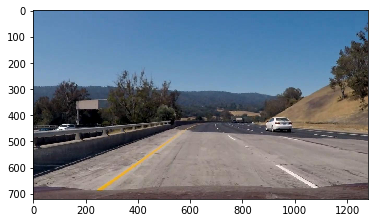

In [475]:
clip_0.save_frame('../test_images/challenge_2.jpg', t=23.89)

image = cv2.imread('../test_images/challenge_2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

(720, 1280)


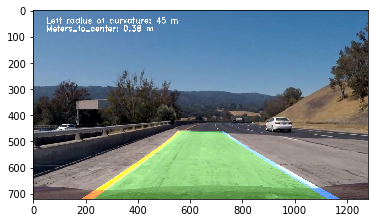

In [476]:


(cal_objpoints, cal_imgpoints) = get_camera_calibration_points()

right_line = Line()
left_line = Line()

def pipeline(init_image, right_line, left_line):
    ##constants
    src_points = np.float32([[179, 720], [1140, 720], [740, 460], [550, 460]])
    dest_points = np.float32([[350, 720], [977, 720], [977, 0], [350, 0]]) 
    window_width=30
    window_height=80
    margin=25
    meters_pp_y = 10/720
    meters_pp_x = 4/380
    #first undistort 
    undistorted=undistort(init_image, cal_objpoints, cal_imgpoints)  
    masked_image= color_and_gradient_filter(undistorted, ksize = 15)
    warped = warp(masked_image,src_points, dest_points)
    (leftx, rightx, curve_centers) = get_window_centers(warped)
    
    #update lines
    right_line.recent_xfitted.append(rightx)
    right_line.allx = rightx
    left_line.recent_xfitted.append(leftx)
    right_line.allx = leftx
    
    final_image = get_final_image(init_image, warped, leftx, rightx, curve_centers, window_height,window_width,
                                 src_points=src_points,dest_points=dest_points,
                                 right_line=right_line, left_line=left_line)
    return final_image

plt.imshow(pipeline(image, right_line, left_line))
plt.show()



../test_images/challenge_1.jpg


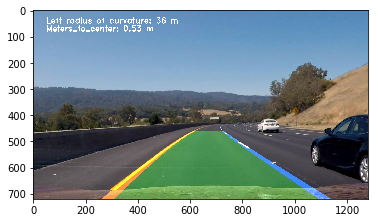

../test_images/challenge_2.jpg


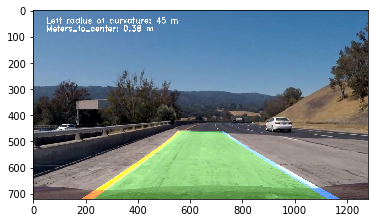

../test_images/straight_lines1.jpg


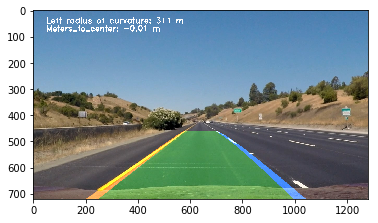

../test_images/straight_lines2.jpg


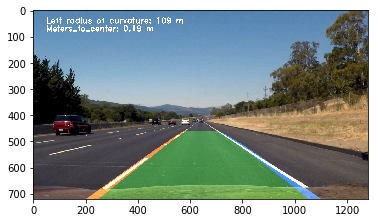

../test_images/test1.jpg


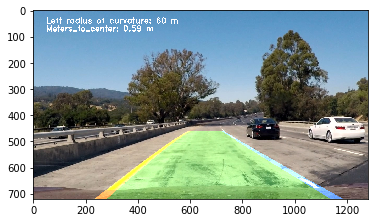

../test_images/test2.jpg


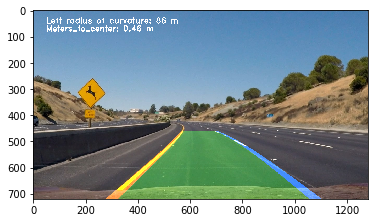

../test_images/test3.jpg


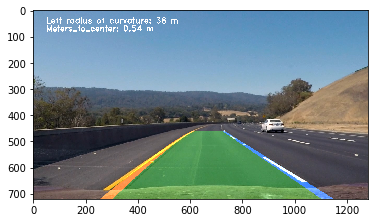

../test_images/test4.jpg


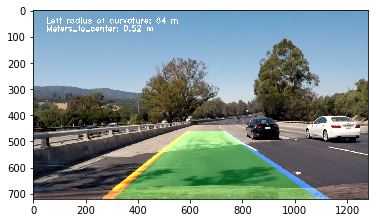

../test_images/test5.jpg


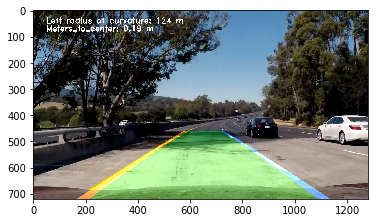

../test_images/test6.jpg


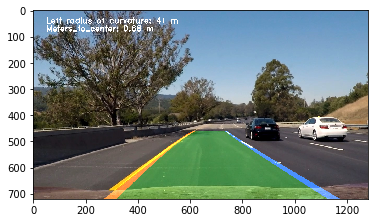

In [496]:

images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    right_line = Line()
    left_line = Line()
    decorated= pipeline(img, right_line, left_line)
    print(fname)
    plt.imshow(decorated)
    plt.show()


In [478]:
from moviepy.editor import VideoFileClip
output_video = 'result.mp4'
input_video = '../project_video.mp4'
right_line = Line(n=2)
left_line = Line(n=2)
clip_0 = VideoFileClip(input_video)
result_video = clip_0.fl_image(lambda image : pipeline(image, right_line, left_line))
%time result_video.write_videofile(output_video, audio=False)

(720, 1280)
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


  0%|          | 1/1261 [00:00<18:25,  1.14it/s]

(720, 1280)


  0%|          | 2/1261 [00:01<18:53,  1.11it/s]

(720, 1280)


  0%|          | 3/1261 [00:02<18:56,  1.11it/s]

(720, 1280)


  0%|          | 4/1261 [00:03<18:47,  1.12it/s]

(720, 1280)


  0%|          | 5/1261 [00:04<18:38,  1.12it/s]

(720, 1280)


  0%|          | 6/1261 [00:05<18:33,  1.13it/s]

(720, 1280)


  1%|          | 7/1261 [00:06<19:13,  1.09it/s]

(720, 1280)


  1%|          | 8/1261 [00:07<20:01,  1.04it/s]

(720, 1280)


  1%|          | 9/1261 [00:09<21:06,  1.01s/it]

(720, 1280)


  1%|          | 10/1261 [00:10<21:47,  1.05s/it]

(720, 1280)


  1%|          | 11/1261 [00:13<25:16,  1.21s/it]

(720, 1280)


  1%|          | 12/1261 [00:15<26:34,  1.28s/it]

(720, 1280)


  1%|          | 13/1261 [00:16<26:46,  1.29s/it]

(720, 1280)


  1%|          | 14/1261 [00:18<26:50,  1.29s/it]

(720, 1280)


  1%|          | 15/1261 [00:19<26:37,  1.28s/it]

(720, 1280)


  1%|▏         | 16/1261 [00:20<26:25,  1.27s/it]

(720, 1280)


  1%|▏         | 17/1261 [00:21<26:26,  1.28s/it]

(720, 1280)


  1%|▏         | 18/1261 [00:22<26:11,  1.26s/it]

(720, 1280)


  2%|▏         | 19/1261 [00:23<25:56,  1.25s/it]

(720, 1280)


  2%|▏         | 20/1261 [00:24<25:42,  1.24s/it]

(720, 1280)


  2%|▏         | 21/1261 [00:26<25:36,  1.24s/it]

(720, 1280)


  2%|▏         | 22/1261 [00:29<27:15,  1.32s/it]

(720, 1280)


  2%|▏         | 23/1261 [00:31<28:09,  1.36s/it]

(720, 1280)


  2%|▏         | 24/1261 [00:33<28:48,  1.40s/it]

(720, 1280)


  2%|▏         | 25/1261 [00:34<28:34,  1.39s/it]

(720, 1280)


  2%|▏         | 26/1261 [00:35<28:15,  1.37s/it]

(720, 1280)


  2%|▏         | 27/1261 [00:36<27:57,  1.36s/it]

(720, 1280)


  2%|▏         | 28/1261 [00:37<27:42,  1.35s/it]

(720, 1280)


  2%|▏         | 29/1261 [00:38<27:30,  1.34s/it]

(720, 1280)


  2%|▏         | 30/1261 [00:39<27:21,  1.33s/it]

(720, 1280)


  2%|▏         | 31/1261 [00:41<27:18,  1.33s/it]

(720, 1280)


  3%|▎         | 32/1261 [00:42<27:12,  1.33s/it]

(720, 1280)


  3%|▎         | 33/1261 [00:43<27:07,  1.33s/it]

(720, 1280)


  3%|▎         | 34/1261 [00:44<27:00,  1.32s/it]

(720, 1280)


  3%|▎         | 35/1261 [00:46<26:55,  1.32s/it]

(720, 1280)


  3%|▎         | 36/1261 [00:47<26:48,  1.31s/it]

(720, 1280)


  3%|▎         | 37/1261 [00:48<26:39,  1.31s/it]

(720, 1280)


  3%|▎         | 38/1261 [00:49<26:30,  1.30s/it]

(720, 1280)


  3%|▎         | 39/1261 [00:50<26:21,  1.29s/it]

(720, 1280)


  3%|▎         | 40/1261 [00:51<26:14,  1.29s/it]

(720, 1280)


  3%|▎         | 41/1261 [00:52<26:06,  1.28s/it]

(720, 1280)


  3%|▎         | 42/1261 [00:53<25:56,  1.28s/it]

(720, 1280)


  3%|▎         | 43/1261 [00:54<25:49,  1.27s/it]

(720, 1280)


  3%|▎         | 44/1261 [00:55<25:42,  1.27s/it]

(720, 1280)


  4%|▎         | 45/1261 [00:56<25:37,  1.26s/it]

(720, 1280)


  4%|▎         | 46/1261 [00:57<25:30,  1.26s/it]

(720, 1280)


  4%|▎         | 47/1261 [00:58<25:22,  1.25s/it]

(720, 1280)


  4%|▍         | 48/1261 [00:59<25:14,  1.25s/it]

(720, 1280)


  4%|▍         | 49/1261 [01:00<25:06,  1.24s/it]

(720, 1280)


  4%|▍         | 50/1261 [01:01<24:56,  1.24s/it]

(720, 1280)


  4%|▍         | 51/1261 [01:02<24:47,  1.23s/it]

(720, 1280)


  4%|▍         | 52/1261 [01:03<24:38,  1.22s/it]

(720, 1280)


  4%|▍         | 53/1261 [01:04<24:30,  1.22s/it]

(720, 1280)


  4%|▍         | 54/1261 [01:05<24:22,  1.21s/it]

(720, 1280)


  4%|▍         | 55/1261 [01:06<24:14,  1.21s/it]

(720, 1280)


  4%|▍         | 56/1261 [01:07<24:06,  1.20s/it]

(720, 1280)


  5%|▍         | 57/1261 [01:08<23:59,  1.20s/it]

(720, 1280)


  5%|▍         | 58/1261 [01:09<23:52,  1.19s/it]

(720, 1280)


  5%|▍         | 59/1261 [01:10<23:47,  1.19s/it]

(720, 1280)


  5%|▍         | 60/1261 [01:11<23:41,  1.18s/it]

(720, 1280)


  5%|▍         | 61/1261 [01:11<23:35,  1.18s/it]

(720, 1280)


  5%|▍         | 62/1261 [01:12<23:28,  1.17s/it]

(720, 1280)


  5%|▍         | 63/1261 [01:13<23:22,  1.17s/it]

(720, 1280)


  5%|▌         | 64/1261 [01:14<23:15,  1.17s/it]

(720, 1280)


  5%|▌         | 65/1261 [01:15<23:09,  1.16s/it]

(720, 1280)


  5%|▌         | 66/1261 [01:16<23:03,  1.16s/it]

(720, 1280)


  5%|▌         | 67/1261 [01:17<22:57,  1.15s/it]

(720, 1280)


  5%|▌         | 68/1261 [01:18<22:53,  1.15s/it]

(720, 1280)


  5%|▌         | 69/1261 [01:19<22:47,  1.15s/it]

(720, 1280)


  6%|▌         | 70/1261 [01:20<22:41,  1.14s/it]

(720, 1280)


  6%|▌         | 71/1261 [01:20<22:36,  1.14s/it]

(720, 1280)


  6%|▌         | 72/1261 [01:21<22:31,  1.14s/it]

(720, 1280)


  6%|▌         | 73/1261 [01:22<22:25,  1.13s/it]

(720, 1280)


  6%|▌         | 74/1261 [01:23<22:21,  1.13s/it]

(720, 1280)


  6%|▌         | 75/1261 [01:24<22:16,  1.13s/it]

(720, 1280)


  6%|▌         | 76/1261 [01:25<22:11,  1.12s/it]

(720, 1280)


  6%|▌         | 77/1261 [01:26<22:06,  1.12s/it]

(720, 1280)


  6%|▌         | 78/1261 [01:27<22:02,  1.12s/it]

(720, 1280)


  6%|▋         | 79/1261 [01:28<21:57,  1.11s/it]

(720, 1280)


  6%|▋         | 80/1261 [01:28<21:53,  1.11s/it]

(720, 1280)


  6%|▋         | 81/1261 [01:29<21:49,  1.11s/it]

(720, 1280)


  7%|▋         | 82/1261 [01:30<21:44,  1.11s/it]

(720, 1280)


  7%|▋         | 83/1261 [01:31<21:40,  1.10s/it]

(720, 1280)


  7%|▋         | 84/1261 [01:32<21:36,  1.10s/it]

(720, 1280)


  7%|▋         | 85/1261 [01:33<21:32,  1.10s/it]

(720, 1280)


  7%|▋         | 86/1261 [01:34<21:28,  1.10s/it]

(720, 1280)


  7%|▋         | 87/1261 [01:35<21:24,  1.09s/it]

(720, 1280)


  7%|▋         | 88/1261 [01:36<21:21,  1.09s/it]

(720, 1280)


  7%|▋         | 89/1261 [01:37<21:17,  1.09s/it]

(720, 1280)


  7%|▋         | 90/1261 [01:37<21:13,  1.09s/it]

(720, 1280)


  7%|▋         | 91/1261 [01:38<21:10,  1.09s/it]

(720, 1280)


  7%|▋         | 92/1261 [01:39<21:06,  1.08s/it]

(720, 1280)


  7%|▋         | 93/1261 [01:40<21:03,  1.08s/it]

(720, 1280)


  7%|▋         | 94/1261 [01:41<20:59,  1.08s/it]

(720, 1280)


  8%|▊         | 95/1261 [01:42<20:56,  1.08s/it]

(720, 1280)


  8%|▊         | 96/1261 [01:43<20:52,  1.08s/it]

(720, 1280)


  8%|▊         | 97/1261 [01:44<20:50,  1.07s/it]

(720, 1280)


  8%|▊         | 98/1261 [01:45<20:46,  1.07s/it]

(720, 1280)


  8%|▊         | 99/1261 [01:45<20:43,  1.07s/it]

(720, 1280)


  8%|▊         | 100/1261 [01:46<20:40,  1.07s/it]

(720, 1280)


  8%|▊         | 101/1261 [01:47<20:39,  1.07s/it]

(720, 1280)


  8%|▊         | 102/1261 [01:48<20:36,  1.07s/it]

(720, 1280)


  8%|▊         | 103/1261 [01:49<20:33,  1.07s/it]

(720, 1280)


  8%|▊         | 104/1261 [01:50<20:31,  1.06s/it]

(720, 1280)


  8%|▊         | 105/1261 [01:51<20:28,  1.06s/it]

(720, 1280)


  8%|▊         | 106/1261 [01:52<20:25,  1.06s/it]

(720, 1280)


  8%|▊         | 107/1261 [01:53<20:22,  1.06s/it]

(720, 1280)


  9%|▊         | 108/1261 [01:54<20:20,  1.06s/it]

(720, 1280)


  9%|▊         | 109/1261 [01:55<20:17,  1.06s/it]

(720, 1280)


  9%|▊         | 110/1261 [01:56<20:14,  1.06s/it]

(720, 1280)


  9%|▉         | 111/1261 [01:56<20:12,  1.05s/it]

(720, 1280)


  9%|▉         | 112/1261 [01:57<20:09,  1.05s/it]

(720, 1280)


  9%|▉         | 113/1261 [01:58<20:07,  1.05s/it]

(720, 1280)


  9%|▉         | 114/1261 [01:59<20:04,  1.05s/it]

(720, 1280)


  9%|▉         | 115/1261 [02:00<20:02,  1.05s/it]

(720, 1280)


  9%|▉         | 116/1261 [02:01<19:59,  1.05s/it]

(720, 1280)


  9%|▉         | 117/1261 [02:02<19:57,  1.05s/it]

(720, 1280)


  9%|▉         | 118/1261 [02:03<19:55,  1.05s/it]

(720, 1280)


  9%|▉         | 119/1261 [02:04<19:52,  1.04s/it]

(720, 1280)


 10%|▉         | 120/1261 [02:05<19:49,  1.04s/it]

(720, 1280)


 10%|▉         | 121/1261 [02:06<19:47,  1.04s/it]

(720, 1280)


 10%|▉         | 122/1261 [02:06<19:44,  1.04s/it]

(720, 1280)


 10%|▉         | 123/1261 [02:07<19:42,  1.04s/it]

(720, 1280)


 10%|▉         | 124/1261 [02:08<19:40,  1.04s/it]

(720, 1280)


 10%|▉         | 125/1261 [02:09<19:37,  1.04s/it]

(720, 1280)


 10%|▉         | 126/1261 [02:10<19:36,  1.04s/it]

(720, 1280)


 10%|█         | 127/1261 [02:11<19:35,  1.04s/it]

(720, 1280)


 10%|█         | 128/1261 [02:12<19:33,  1.04s/it]

(720, 1280)


 10%|█         | 129/1261 [02:13<19:31,  1.03s/it]

(720, 1280)


 10%|█         | 130/1261 [02:14<19:28,  1.03s/it]

(720, 1280)


 10%|█         | 131/1261 [02:15<19:26,  1.03s/it]

(720, 1280)


 10%|█         | 132/1261 [02:16<19:24,  1.03s/it]

(720, 1280)


 11%|█         | 133/1261 [02:17<19:22,  1.03s/it]

(720, 1280)


 11%|█         | 134/1261 [02:17<19:19,  1.03s/it]

(720, 1280)


 11%|█         | 135/1261 [02:18<19:18,  1.03s/it]

(720, 1280)


 11%|█         | 136/1261 [02:19<19:16,  1.03s/it]

(720, 1280)


 11%|█         | 137/1261 [02:20<19:14,  1.03s/it]

(720, 1280)


 11%|█         | 138/1261 [02:21<19:12,  1.03s/it]

(720, 1280)


 11%|█         | 139/1261 [02:22<19:09,  1.02s/it]

(720, 1280)


 11%|█         | 140/1261 [02:23<19:07,  1.02s/it]

(720, 1280)


 11%|█         | 141/1261 [02:24<19:05,  1.02s/it]

(720, 1280)


 11%|█▏        | 142/1261 [02:25<19:03,  1.02s/it]

(720, 1280)


 11%|█▏        | 143/1261 [02:26<19:01,  1.02s/it]

(720, 1280)


 11%|█▏        | 144/1261 [02:26<18:59,  1.02s/it]

(720, 1280)


 11%|█▏        | 145/1261 [02:27<18:57,  1.02s/it]

(720, 1280)


 12%|█▏        | 146/1261 [02:28<18:56,  1.02s/it]

(720, 1280)


 12%|█▏        | 147/1261 [02:29<18:55,  1.02s/it]

(720, 1280)


 12%|█▏        | 148/1261 [02:30<18:54,  1.02s/it]

(720, 1280)


 12%|█▏        | 149/1261 [02:31<18:51,  1.02s/it]

(720, 1280)


 12%|█▏        | 150/1261 [02:32<18:50,  1.02s/it]

(720, 1280)


 12%|█▏        | 151/1261 [02:33<18:48,  1.02s/it]

(720, 1280)


 12%|█▏        | 152/1261 [02:34<18:47,  1.02s/it]

(720, 1280)


 12%|█▏        | 153/1261 [02:35<18:47,  1.02s/it]

(720, 1280)


 12%|█▏        | 154/1261 [02:36<18:46,  1.02s/it]

(720, 1280)


 12%|█▏        | 155/1261 [02:37<18:46,  1.02s/it]

(720, 1280)


 12%|█▏        | 156/1261 [02:38<18:45,  1.02s/it]

(720, 1280)


 12%|█▏        | 157/1261 [02:40<18:45,  1.02s/it]

(720, 1280)


 13%|█▎        | 158/1261 [02:41<18:44,  1.02s/it]

(720, 1280)


 13%|█▎        | 159/1261 [02:42<18:44,  1.02s/it]

(720, 1280)


 13%|█▎        | 160/1261 [02:43<18:43,  1.02s/it]

(720, 1280)


 13%|█▎        | 161/1261 [02:44<18:42,  1.02s/it]

(720, 1280)


 13%|█▎        | 162/1261 [02:45<18:42,  1.02s/it]

(720, 1280)


 13%|█▎        | 163/1261 [02:46<18:41,  1.02s/it]

(720, 1280)


 13%|█▎        | 164/1261 [02:47<18:41,  1.02s/it]

(720, 1280)


 13%|█▎        | 165/1261 [02:48<18:40,  1.02s/it]

(720, 1280)


 13%|█▎        | 166/1261 [02:49<18:39,  1.02s/it]

(720, 1280)


 13%|█▎        | 167/1261 [02:50<18:38,  1.02s/it]

(720, 1280)


 13%|█▎        | 168/1261 [02:51<18:36,  1.02s/it]

(720, 1280)


 13%|█▎        | 169/1261 [02:52<18:34,  1.02s/it]

(720, 1280)


 13%|█▎        | 170/1261 [02:53<18:32,  1.02s/it]

(720, 1280)


 14%|█▎        | 171/1261 [02:54<18:31,  1.02s/it]

(720, 1280)


 14%|█▎        | 172/1261 [02:55<18:29,  1.02s/it]

(720, 1280)


 14%|█▎        | 173/1261 [02:56<18:28,  1.02s/it]

(720, 1280)


 14%|█▍        | 174/1261 [02:57<18:26,  1.02s/it]

(720, 1280)


 14%|█▍        | 175/1261 [02:57<18:24,  1.02s/it]

(720, 1280)


 14%|█▍        | 176/1261 [02:58<18:22,  1.02s/it]

(720, 1280)


 14%|█▍        | 177/1261 [02:59<18:21,  1.02s/it]

(720, 1280)


 14%|█▍        | 178/1261 [03:00<18:19,  1.02s/it]

(720, 1280)


 14%|█▍        | 179/1261 [03:01<18:17,  1.01s/it]

(720, 1280)


 14%|█▍        | 180/1261 [03:02<18:15,  1.01s/it]

(720, 1280)


 14%|█▍        | 181/1261 [03:03<18:14,  1.01s/it]

(720, 1280)


 14%|█▍        | 182/1261 [03:04<18:12,  1.01s/it]

(720, 1280)


 15%|█▍        | 183/1261 [03:05<18:10,  1.01s/it]

(720, 1280)


 15%|█▍        | 184/1261 [03:06<18:08,  1.01s/it]

(720, 1280)


 15%|█▍        | 185/1261 [03:06<18:07,  1.01s/it]

(720, 1280)


 15%|█▍        | 186/1261 [03:07<18:05,  1.01s/it]

(720, 1280)


 15%|█▍        | 187/1261 [03:08<18:03,  1.01s/it]

(720, 1280)


 15%|█▍        | 188/1261 [03:09<18:02,  1.01s/it]

(720, 1280)


 15%|█▍        | 189/1261 [03:10<18:00,  1.01s/it]

(720, 1280)


 15%|█▌        | 190/1261 [03:11<17:59,  1.01s/it]

(720, 1280)


 15%|█▌        | 191/1261 [03:12<17:58,  1.01s/it]

(720, 1280)


 15%|█▌        | 192/1261 [03:13<17:57,  1.01s/it]

(720, 1280)


 15%|█▌        | 193/1261 [03:14<17:55,  1.01s/it]

(720, 1280)


 15%|█▌        | 194/1261 [03:15<17:53,  1.01s/it]

(720, 1280)


 15%|█▌        | 195/1261 [03:16<17:52,  1.01s/it]

(720, 1280)


 16%|█▌        | 196/1261 [03:17<17:50,  1.01s/it]

(720, 1280)


 16%|█▌        | 197/1261 [03:17<17:48,  1.00s/it]

(720, 1280)


 16%|█▌        | 198/1261 [03:18<17:47,  1.00s/it]

(720, 1280)


 16%|█▌        | 199/1261 [03:19<17:45,  1.00s/it]

(720, 1280)


 16%|█▌        | 200/1261 [03:20<17:44,  1.00s/it]

(720, 1280)


 16%|█▌        | 201/1261 [03:21<17:43,  1.00s/it]

(720, 1280)


 16%|█▌        | 202/1261 [03:22<17:41,  1.00s/it]

(720, 1280)


 16%|█▌        | 203/1261 [03:23<17:40,  1.00s/it]

(720, 1280)


 16%|█▌        | 204/1261 [03:24<17:38,  1.00s/it]

(720, 1280)


 16%|█▋        | 205/1261 [03:25<17:37,  1.00s/it]

(720, 1280)


 16%|█▋        | 206/1261 [03:26<17:35,  1.00s/it]

(720, 1280)


 16%|█▋        | 207/1261 [03:27<17:34,  1.00s/it]

(720, 1280)


 16%|█▋        | 208/1261 [03:27<17:32,  1.00it/s]

(720, 1280)


 17%|█▋        | 209/1261 [03:28<17:30,  1.00it/s]

(720, 1280)


 17%|█▋        | 210/1261 [03:29<17:29,  1.00it/s]

(720, 1280)


 17%|█▋        | 211/1261 [03:30<17:27,  1.00it/s]

(720, 1280)


 17%|█▋        | 212/1261 [03:31<17:26,  1.00it/s]

(720, 1280)


 17%|█▋        | 213/1261 [03:32<17:24,  1.00it/s]

(720, 1280)


 17%|█▋        | 214/1261 [03:33<17:23,  1.00it/s]

(720, 1280)


 17%|█▋        | 215/1261 [03:34<17:22,  1.00it/s]

(720, 1280)


 17%|█▋        | 216/1261 [03:35<17:20,  1.00it/s]

(720, 1280)


 17%|█▋        | 217/1261 [03:36<17:19,  1.00it/s]

(720, 1280)


 17%|█▋        | 218/1261 [03:36<17:17,  1.01it/s]

(720, 1280)


 17%|█▋        | 219/1261 [03:37<17:16,  1.01it/s]

(720, 1280)


 17%|█▋        | 220/1261 [03:38<17:14,  1.01it/s]

(720, 1280)


 18%|█▊        | 221/1261 [03:39<17:13,  1.01it/s]

(720, 1280)


 18%|█▊        | 222/1261 [03:40<17:11,  1.01it/s]

(720, 1280)


 18%|█▊        | 223/1261 [03:41<17:10,  1.01it/s]

(720, 1280)


 18%|█▊        | 224/1261 [03:42<17:08,  1.01it/s]

(720, 1280)


 18%|█▊        | 225/1261 [03:43<17:07,  1.01it/s]

(720, 1280)


 18%|█▊        | 226/1261 [03:44<17:06,  1.01it/s]

(720, 1280)


 18%|█▊        | 227/1261 [03:44<17:04,  1.01it/s]

(720, 1280)


 18%|█▊        | 228/1261 [03:45<17:03,  1.01it/s]

(720, 1280)


 18%|█▊        | 229/1261 [03:46<17:02,  1.01it/s]

(720, 1280)


 18%|█▊        | 230/1261 [03:47<17:00,  1.01it/s]

(720, 1280)


 18%|█▊        | 231/1261 [03:48<16:59,  1.01it/s]

(720, 1280)


 18%|█▊        | 232/1261 [03:49<16:58,  1.01it/s]

(720, 1280)


 18%|█▊        | 233/1261 [03:50<16:57,  1.01it/s]

(720, 1280)


 19%|█▊        | 234/1261 [03:51<16:55,  1.01it/s]

(720, 1280)


 19%|█▊        | 235/1261 [03:52<16:54,  1.01it/s]

(720, 1280)


 19%|█▊        | 236/1261 [03:53<16:52,  1.01it/s]

(720, 1280)


 19%|█▉        | 237/1261 [03:54<16:51,  1.01it/s]

(720, 1280)


 19%|█▉        | 238/1261 [03:54<16:50,  1.01it/s]

(720, 1280)


 19%|█▉        | 239/1261 [03:55<16:48,  1.01it/s]

(720, 1280)


 19%|█▉        | 240/1261 [03:56<16:47,  1.01it/s]

(720, 1280)


 19%|█▉        | 241/1261 [03:57<16:45,  1.01it/s]

(720, 1280)


 19%|█▉        | 242/1261 [03:58<16:44,  1.01it/s]

(720, 1280)


 19%|█▉        | 243/1261 [03:59<16:43,  1.01it/s]

(720, 1280)


 19%|█▉        | 244/1261 [04:00<16:42,  1.01it/s]

(720, 1280)


 19%|█▉        | 245/1261 [04:01<16:40,  1.02it/s]

(720, 1280)


 20%|█▉        | 246/1261 [04:02<16:39,  1.02it/s]

(720, 1280)


 20%|█▉        | 247/1261 [04:03<16:37,  1.02it/s]

(720, 1280)


 20%|█▉        | 248/1261 [04:03<16:36,  1.02it/s]

(720, 1280)


 20%|█▉        | 249/1261 [04:04<16:35,  1.02it/s]

(720, 1280)


 20%|█▉        | 250/1261 [04:05<16:33,  1.02it/s]

(720, 1280)


 20%|█▉        | 251/1261 [04:06<16:32,  1.02it/s]

(720, 1280)


 20%|█▉        | 252/1261 [04:07<16:31,  1.02it/s]

(720, 1280)


 20%|██        | 253/1261 [04:08<16:29,  1.02it/s]

(720, 1280)


 20%|██        | 254/1261 [04:09<16:28,  1.02it/s]

(720, 1280)


 20%|██        | 255/1261 [04:10<16:27,  1.02it/s]

(720, 1280)


 20%|██        | 256/1261 [04:11<16:25,  1.02it/s]

(720, 1280)


 20%|██        | 257/1261 [04:12<16:24,  1.02it/s]

(720, 1280)


 20%|██        | 258/1261 [04:13<16:23,  1.02it/s]

(720, 1280)


 21%|██        | 259/1261 [04:14<16:22,  1.02it/s]

(720, 1280)


 21%|██        | 260/1261 [04:14<16:21,  1.02it/s]

(720, 1280)


 21%|██        | 261/1261 [04:15<16:20,  1.02it/s]

(720, 1280)


 21%|██        | 262/1261 [04:16<16:19,  1.02it/s]

(720, 1280)


 21%|██        | 263/1261 [04:17<16:17,  1.02it/s]

(720, 1280)


 21%|██        | 264/1261 [04:18<16:16,  1.02it/s]

(720, 1280)


 21%|██        | 265/1261 [04:19<16:15,  1.02it/s]

(720, 1280)


 21%|██        | 266/1261 [04:20<16:13,  1.02it/s]

(720, 1280)


 21%|██        | 267/1261 [04:21<16:12,  1.02it/s]

(720, 1280)


 21%|██▏       | 268/1261 [04:22<16:11,  1.02it/s]

(720, 1280)


 21%|██▏       | 269/1261 [04:23<16:10,  1.02it/s]

(720, 1280)


 21%|██▏       | 270/1261 [04:23<16:08,  1.02it/s]

(720, 1280)


 21%|██▏       | 271/1261 [04:24<16:07,  1.02it/s]

(720, 1280)


 22%|██▏       | 272/1261 [04:25<16:06,  1.02it/s]

(720, 1280)


 22%|██▏       | 273/1261 [04:26<16:04,  1.02it/s]

(720, 1280)


 22%|██▏       | 274/1261 [04:27<16:03,  1.02it/s]

(720, 1280)


 22%|██▏       | 275/1261 [04:28<16:02,  1.02it/s]

(720, 1280)


 22%|██▏       | 276/1261 [04:30<16:03,  1.02it/s]

(720, 1280)


 22%|██▏       | 277/1261 [04:31<16:03,  1.02it/s]

(720, 1280)


 22%|██▏       | 278/1261 [04:32<16:03,  1.02it/s]

(720, 1280)


 22%|██▏       | 279/1261 [04:33<16:02,  1.02it/s]

(720, 1280)


 22%|██▏       | 280/1261 [04:34<16:01,  1.02it/s]

(720, 1280)


 22%|██▏       | 281/1261 [04:35<16:00,  1.02it/s]

(720, 1280)


 22%|██▏       | 282/1261 [04:36<15:59,  1.02it/s]

(720, 1280)


 22%|██▏       | 283/1261 [04:37<15:58,  1.02it/s]

(720, 1280)


 23%|██▎       | 284/1261 [04:38<15:57,  1.02it/s]

(720, 1280)


 23%|██▎       | 285/1261 [04:39<15:57,  1.02it/s]

(720, 1280)


 23%|██▎       | 286/1261 [04:40<15:56,  1.02it/s]

(720, 1280)


 23%|██▎       | 287/1261 [04:41<15:55,  1.02it/s]

(720, 1280)


 23%|██▎       | 288/1261 [04:42<15:55,  1.02it/s]

(720, 1280)


 23%|██▎       | 289/1261 [04:43<15:54,  1.02it/s]

(720, 1280)


 23%|██▎       | 290/1261 [04:44<15:54,  1.02it/s]

(720, 1280)


 23%|██▎       | 291/1261 [04:46<15:53,  1.02it/s]

(720, 1280)


 23%|██▎       | 292/1261 [04:47<15:53,  1.02it/s]

(720, 1280)


 23%|██▎       | 293/1261 [04:48<15:52,  1.02it/s]

(720, 1280)


 23%|██▎       | 294/1261 [04:49<15:51,  1.02it/s]

(720, 1280)


 23%|██▎       | 295/1261 [04:50<15:51,  1.02it/s]

(720, 1280)


 23%|██▎       | 296/1261 [04:52<15:52,  1.01it/s]

(720, 1280)


 24%|██▎       | 297/1261 [04:53<15:52,  1.01it/s]

(720, 1280)


 24%|██▎       | 298/1261 [04:54<15:51,  1.01it/s]

(720, 1280)


 24%|██▎       | 299/1261 [04:55<15:50,  1.01it/s]

(720, 1280)


 24%|██▍       | 300/1261 [04:56<15:49,  1.01it/s]

(720, 1280)


 24%|██▍       | 301/1261 [04:57<15:48,  1.01it/s]

(720, 1280)


 24%|██▍       | 302/1261 [04:58<15:47,  1.01it/s]

(720, 1280)


 24%|██▍       | 303/1261 [04:59<15:45,  1.01it/s]

(720, 1280)


 24%|██▍       | 304/1261 [05:00<15:44,  1.01it/s]

(720, 1280)


 24%|██▍       | 305/1261 [05:00<15:43,  1.01it/s]

(720, 1280)


 24%|██▍       | 306/1261 [05:01<15:42,  1.01it/s]

(720, 1280)


 24%|██▍       | 307/1261 [05:02<15:40,  1.01it/s]

(720, 1280)


 24%|██▍       | 308/1261 [05:03<15:39,  1.01it/s]

(720, 1280)


 25%|██▍       | 309/1261 [05:04<15:38,  1.01it/s]

(720, 1280)


 25%|██▍       | 310/1261 [05:05<15:37,  1.01it/s]

(720, 1280)


 25%|██▍       | 311/1261 [05:06<15:35,  1.02it/s]

(720, 1280)


 25%|██▍       | 312/1261 [05:07<15:34,  1.02it/s]

(720, 1280)


 25%|██▍       | 313/1261 [05:08<15:33,  1.02it/s]

(720, 1280)


 25%|██▍       | 314/1261 [05:09<15:31,  1.02it/s]

(720, 1280)


 25%|██▍       | 315/1261 [05:09<15:30,  1.02it/s]

(720, 1280)


 25%|██▌       | 316/1261 [05:10<15:29,  1.02it/s]

(720, 1280)


 25%|██▌       | 317/1261 [05:11<15:28,  1.02it/s]

(720, 1280)


 25%|██▌       | 318/1261 [05:12<15:26,  1.02it/s]

(720, 1280)


 25%|██▌       | 319/1261 [05:13<15:26,  1.02it/s]

(720, 1280)


 25%|██▌       | 320/1261 [05:14<15:25,  1.02it/s]

(720, 1280)


 25%|██▌       | 321/1261 [05:15<15:24,  1.02it/s]

(720, 1280)


 26%|██▌       | 322/1261 [05:16<15:22,  1.02it/s]

(720, 1280)


 26%|██▌       | 323/1261 [05:17<15:21,  1.02it/s]

(720, 1280)


 26%|██▌       | 324/1261 [05:18<15:20,  1.02it/s]

(720, 1280)


 26%|██▌       | 325/1261 [05:19<15:19,  1.02it/s]

(720, 1280)


 26%|██▌       | 326/1261 [05:20<15:18,  1.02it/s]

(720, 1280)


 26%|██▌       | 327/1261 [05:21<15:16,  1.02it/s]

(720, 1280)


 26%|██▌       | 328/1261 [05:21<15:15,  1.02it/s]

(720, 1280)


 26%|██▌       | 329/1261 [05:22<15:14,  1.02it/s]

(720, 1280)


 26%|██▌       | 330/1261 [05:23<15:13,  1.02it/s]

(720, 1280)


 26%|██▌       | 331/1261 [05:24<15:12,  1.02it/s]

(720, 1280)


 26%|██▋       | 332/1261 [05:25<15:11,  1.02it/s]

(720, 1280)


 26%|██▋       | 333/1261 [05:26<15:09,  1.02it/s]

(720, 1280)


 26%|██▋       | 334/1261 [05:27<15:08,  1.02it/s]

(720, 1280)


 27%|██▋       | 335/1261 [05:28<15:08,  1.02it/s]

(720, 1280)


 27%|██▋       | 336/1261 [05:29<15:06,  1.02it/s]

(720, 1280)


 27%|██▋       | 337/1261 [05:30<15:05,  1.02it/s]

(720, 1280)


 27%|██▋       | 338/1261 [05:31<15:04,  1.02it/s]

(720, 1280)


 27%|██▋       | 339/1261 [05:32<15:03,  1.02it/s]

(720, 1280)


 27%|██▋       | 340/1261 [05:33<15:02,  1.02it/s]

(720, 1280)


 27%|██▋       | 341/1261 [05:33<15:00,  1.02it/s]

(720, 1280)


 27%|██▋       | 342/1261 [05:34<14:59,  1.02it/s]

(720, 1280)


 27%|██▋       | 343/1261 [05:35<14:58,  1.02it/s]

(720, 1280)


 27%|██▋       | 344/1261 [05:36<14:57,  1.02it/s]

(720, 1280)


 27%|██▋       | 345/1261 [05:37<14:56,  1.02it/s]

(720, 1280)


 27%|██▋       | 346/1261 [05:38<14:55,  1.02it/s]

(720, 1280)


 28%|██▊       | 347/1261 [05:39<14:53,  1.02it/s]

(720, 1280)


 28%|██▊       | 348/1261 [05:40<14:52,  1.02it/s]

(720, 1280)


 28%|██▊       | 349/1261 [05:41<14:51,  1.02it/s]

(720, 1280)


 28%|██▊       | 350/1261 [05:42<14:50,  1.02it/s]

(720, 1280)


 28%|██▊       | 351/1261 [05:42<14:49,  1.02it/s]

(720, 1280)


 28%|██▊       | 352/1261 [05:43<14:47,  1.02it/s]

(720, 1280)


 28%|██▊       | 353/1261 [05:44<14:46,  1.02it/s]

(720, 1280)


 28%|██▊       | 354/1261 [05:45<14:45,  1.02it/s]

(720, 1280)


 28%|██▊       | 355/1261 [05:46<14:44,  1.02it/s]

(720, 1280)


 28%|██▊       | 356/1261 [05:47<14:43,  1.02it/s]

(720, 1280)


 28%|██▊       | 357/1261 [05:48<14:42,  1.02it/s]

(720, 1280)


 28%|██▊       | 358/1261 [05:49<14:41,  1.02it/s]

(720, 1280)


 28%|██▊       | 359/1261 [05:50<14:40,  1.02it/s]

(720, 1280)


 29%|██▊       | 360/1261 [05:51<14:39,  1.02it/s]

(720, 1280)


 29%|██▊       | 361/1261 [05:52<14:38,  1.02it/s]

(720, 1280)


 29%|██▊       | 362/1261 [05:53<14:36,  1.03it/s]

(720, 1280)


 29%|██▉       | 363/1261 [05:54<14:35,  1.03it/s]

(720, 1280)


 29%|██▉       | 364/1261 [05:54<14:34,  1.03it/s]

(720, 1280)


 29%|██▉       | 365/1261 [05:55<14:33,  1.03it/s]

(720, 1280)


 29%|██▉       | 366/1261 [05:56<14:32,  1.03it/s]

(720, 1280)


 29%|██▉       | 367/1261 [05:57<14:31,  1.03it/s]

(720, 1280)


 29%|██▉       | 368/1261 [05:58<14:29,  1.03it/s]

(720, 1280)


 29%|██▉       | 369/1261 [05:59<14:28,  1.03it/s]

(720, 1280)


 29%|██▉       | 370/1261 [06:00<14:27,  1.03it/s]

(720, 1280)


 29%|██▉       | 371/1261 [06:01<14:26,  1.03it/s]

(720, 1280)


 30%|██▉       | 372/1261 [06:02<14:25,  1.03it/s]

(720, 1280)


 30%|██▉       | 373/1261 [06:03<14:24,  1.03it/s]

(720, 1280)


 30%|██▉       | 374/1261 [06:03<14:23,  1.03it/s]

(720, 1280)


 30%|██▉       | 375/1261 [06:04<14:21,  1.03it/s]

(720, 1280)


 30%|██▉       | 376/1261 [06:05<14:20,  1.03it/s]

(720, 1280)


 30%|██▉       | 377/1261 [06:06<14:19,  1.03it/s]

(720, 1280)


 30%|██▉       | 378/1261 [06:07<14:18,  1.03it/s]

(720, 1280)


 30%|███       | 379/1261 [06:08<14:17,  1.03it/s]

(720, 1280)


 30%|███       | 380/1261 [06:09<14:16,  1.03it/s]

(720, 1280)


 30%|███       | 381/1261 [06:10<14:15,  1.03it/s]

(720, 1280)


 30%|███       | 382/1261 [06:11<14:14,  1.03it/s]

(720, 1280)


 30%|███       | 383/1261 [06:12<14:12,  1.03it/s]

(720, 1280)


 30%|███       | 384/1261 [06:12<14:11,  1.03it/s]

(720, 1280)


 31%|███       | 385/1261 [06:13<14:10,  1.03it/s]

(720, 1280)


 31%|███       | 386/1261 [06:14<14:09,  1.03it/s]

(720, 1280)


 31%|███       | 387/1261 [06:15<14:08,  1.03it/s]

(720, 1280)


 31%|███       | 388/1261 [06:16<14:07,  1.03it/s]

(720, 1280)


 31%|███       | 389/1261 [06:17<14:06,  1.03it/s]

(720, 1280)


 31%|███       | 390/1261 [06:18<14:05,  1.03it/s]

(720, 1280)


 31%|███       | 391/1261 [06:19<14:04,  1.03it/s]

(720, 1280)


 31%|███       | 392/1261 [06:20<14:03,  1.03it/s]

(720, 1280)


 31%|███       | 393/1261 [06:21<14:02,  1.03it/s]

(720, 1280)


 31%|███       | 394/1261 [06:22<14:01,  1.03it/s]

(720, 1280)


 31%|███▏      | 395/1261 [06:23<14:00,  1.03it/s]

(720, 1280)


 31%|███▏      | 396/1261 [06:24<13:59,  1.03it/s]

(720, 1280)


 31%|███▏      | 397/1261 [06:25<13:58,  1.03it/s]

(720, 1280)


 32%|███▏      | 398/1261 [06:25<13:56,  1.03it/s]

(720, 1280)


 32%|███▏      | 399/1261 [06:26<13:55,  1.03it/s]

(720, 1280)


 32%|███▏      | 400/1261 [06:27<13:54,  1.03it/s]

(720, 1280)


 32%|███▏      | 401/1261 [06:28<13:53,  1.03it/s]

(720, 1280)


 32%|███▏      | 402/1261 [06:29<13:52,  1.03it/s]

(720, 1280)


 32%|███▏      | 403/1261 [06:30<13:51,  1.03it/s]

(720, 1280)


 32%|███▏      | 404/1261 [06:31<13:51,  1.03it/s]

(720, 1280)


 32%|███▏      | 405/1261 [06:33<13:51,  1.03it/s]

(720, 1280)


 32%|███▏      | 406/1261 [06:34<13:50,  1.03it/s]

(720, 1280)


 32%|███▏      | 407/1261 [06:35<13:49,  1.03it/s]

(720, 1280)


 32%|███▏      | 408/1261 [06:36<13:48,  1.03it/s]

(720, 1280)


 32%|███▏      | 409/1261 [06:37<13:47,  1.03it/s]

(720, 1280)


 33%|███▎      | 410/1261 [06:38<13:46,  1.03it/s]

(720, 1280)


 33%|███▎      | 411/1261 [06:39<13:45,  1.03it/s]

(720, 1280)


 33%|███▎      | 412/1261 [06:40<13:45,  1.03it/s]

(720, 1280)


 33%|███▎      | 413/1261 [06:41<13:44,  1.03it/s]

(720, 1280)


 33%|███▎      | 414/1261 [06:42<13:44,  1.03it/s]

(720, 1280)


 33%|███▎      | 415/1261 [06:44<13:43,  1.03it/s]

(720, 1280)


 33%|███▎      | 416/1261 [06:45<13:43,  1.03it/s]

(720, 1280)


 33%|███▎      | 417/1261 [06:46<13:42,  1.03it/s]

(720, 1280)


 33%|███▎      | 418/1261 [06:47<13:42,  1.03it/s]

(720, 1280)


 33%|███▎      | 419/1261 [06:49<13:42,  1.02it/s]

(720, 1280)


 33%|███▎      | 420/1261 [06:50<13:41,  1.02it/s]

(720, 1280)


 33%|███▎      | 421/1261 [06:51<13:41,  1.02it/s]

(720, 1280)


 33%|███▎      | 422/1261 [06:52<13:40,  1.02it/s]

(720, 1280)


 34%|███▎      | 423/1261 [06:53<13:39,  1.02it/s]

(720, 1280)


 34%|███▎      | 424/1261 [06:54<13:38,  1.02it/s]

(720, 1280)


 34%|███▎      | 425/1261 [06:55<13:37,  1.02it/s]

(720, 1280)


 34%|███▍      | 426/1261 [06:56<13:36,  1.02it/s]

(720, 1280)


 34%|███▍      | 427/1261 [06:57<13:35,  1.02it/s]

(720, 1280)


 34%|███▍      | 428/1261 [06:58<13:34,  1.02it/s]

(720, 1280)


 34%|███▍      | 429/1261 [06:59<13:32,  1.02it/s]

(720, 1280)


 34%|███▍      | 430/1261 [07:00<13:31,  1.02it/s]

(720, 1280)


 34%|███▍      | 431/1261 [07:00<13:30,  1.02it/s]

(720, 1280)


 34%|███▍      | 432/1261 [07:01<13:29,  1.02it/s]

(720, 1280)


 34%|███▍      | 433/1261 [07:02<13:28,  1.02it/s]

(720, 1280)


 34%|███▍      | 434/1261 [07:03<13:27,  1.02it/s]

(720, 1280)


 34%|███▍      | 435/1261 [07:04<13:26,  1.02it/s]

(720, 1280)


 35%|███▍      | 436/1261 [07:05<13:25,  1.02it/s]

(720, 1280)


 35%|███▍      | 437/1261 [07:06<13:24,  1.02it/s]

(720, 1280)


 35%|███▍      | 438/1261 [07:07<13:23,  1.02it/s]

(720, 1280)


 35%|███▍      | 439/1261 [07:08<13:21,  1.03it/s]

(720, 1280)


 35%|███▍      | 440/1261 [07:09<13:20,  1.03it/s]

(720, 1280)


 35%|███▍      | 441/1261 [07:10<13:19,  1.03it/s]

(720, 1280)


 35%|███▌      | 442/1261 [07:10<13:18,  1.03it/s]

(720, 1280)


 35%|███▌      | 443/1261 [07:11<13:17,  1.03it/s]

(720, 1280)


 35%|███▌      | 444/1261 [07:12<13:16,  1.03it/s]

(720, 1280)


 35%|███▌      | 445/1261 [07:13<13:15,  1.03it/s]

(720, 1280)


 35%|███▌      | 446/1261 [07:14<13:14,  1.03it/s]

(720, 1280)


 35%|███▌      | 447/1261 [07:15<13:13,  1.03it/s]

(720, 1280)


 36%|███▌      | 448/1261 [07:16<13:12,  1.03it/s]

(720, 1280)


 36%|███▌      | 449/1261 [07:17<13:11,  1.03it/s]

(720, 1280)


 36%|███▌      | 450/1261 [07:18<13:10,  1.03it/s]

(720, 1280)


 36%|███▌      | 451/1261 [07:19<13:09,  1.03it/s]

(720, 1280)


 36%|███▌      | 452/1261 [07:20<13:07,  1.03it/s]

(720, 1280)


 36%|███▌      | 453/1261 [07:21<13:06,  1.03it/s]

(720, 1280)


 36%|███▌      | 454/1261 [07:22<13:05,  1.03it/s]

(720, 1280)


 36%|███▌      | 455/1261 [07:22<13:04,  1.03it/s]

(720, 1280)


 36%|███▌      | 456/1261 [07:23<13:03,  1.03it/s]

(720, 1280)


 36%|███▌      | 457/1261 [07:24<13:02,  1.03it/s]

(720, 1280)


 36%|███▋      | 458/1261 [07:25<13:01,  1.03it/s]

(720, 1280)


 36%|███▋      | 459/1261 [07:26<13:00,  1.03it/s]

(720, 1280)


 36%|███▋      | 460/1261 [07:27<12:59,  1.03it/s]

(720, 1280)


 37%|███▋      | 461/1261 [07:28<12:58,  1.03it/s]

(720, 1280)


 37%|███▋      | 462/1261 [07:29<12:57,  1.03it/s]

(720, 1280)


 37%|███▋      | 463/1261 [07:30<12:55,  1.03it/s]

(720, 1280)


 37%|███▋      | 464/1261 [07:31<12:54,  1.03it/s]

(720, 1280)


 37%|███▋      | 465/1261 [07:32<12:53,  1.03it/s]

(720, 1280)


 37%|███▋      | 466/1261 [07:32<12:52,  1.03it/s]

(720, 1280)


 37%|███▋      | 467/1261 [07:33<12:51,  1.03it/s]

(720, 1280)


 37%|███▋      | 468/1261 [07:34<12:50,  1.03it/s]

(720, 1280)


 37%|███▋      | 469/1261 [07:35<12:49,  1.03it/s]

(720, 1280)


 37%|███▋      | 470/1261 [07:36<12:48,  1.03it/s]

(720, 1280)


 37%|███▋      | 471/1261 [07:37<12:47,  1.03it/s]

(720, 1280)


 37%|███▋      | 472/1261 [07:38<12:46,  1.03it/s]

(720, 1280)


 38%|███▊      | 473/1261 [07:39<12:45,  1.03it/s]

(720, 1280)


 38%|███▊      | 474/1261 [07:40<12:44,  1.03it/s]

(720, 1280)


 38%|███▊      | 475/1261 [07:41<12:43,  1.03it/s]

(720, 1280)


 38%|███▊      | 476/1261 [07:41<12:41,  1.03it/s]

(720, 1280)


 38%|███▊      | 477/1261 [07:42<12:40,  1.03it/s]

(720, 1280)


 38%|███▊      | 478/1261 [07:43<12:39,  1.03it/s]

(720, 1280)


 38%|███▊      | 479/1261 [07:44<12:38,  1.03it/s]

(720, 1280)


 38%|███▊      | 480/1261 [07:45<12:37,  1.03it/s]

(720, 1280)


 38%|███▊      | 481/1261 [07:46<12:36,  1.03it/s]

(720, 1280)


 38%|███▊      | 482/1261 [07:47<12:35,  1.03it/s]

(720, 1280)


 38%|███▊      | 483/1261 [07:48<12:34,  1.03it/s]

(720, 1280)


 38%|███▊      | 484/1261 [07:49<12:33,  1.03it/s]

(720, 1280)


 38%|███▊      | 485/1261 [07:50<12:32,  1.03it/s]

(720, 1280)


 39%|███▊      | 486/1261 [07:51<12:31,  1.03it/s]

(720, 1280)


 39%|███▊      | 487/1261 [07:51<12:30,  1.03it/s]

(720, 1280)


 39%|███▊      | 488/1261 [07:52<12:29,  1.03it/s]

(720, 1280)


 39%|███▉      | 489/1261 [07:53<12:28,  1.03it/s]

(720, 1280)


 39%|███▉      | 490/1261 [07:54<12:26,  1.03it/s]

(720, 1280)


 39%|███▉      | 491/1261 [07:55<12:25,  1.03it/s]

(720, 1280)


 39%|███▉      | 492/1261 [07:56<12:24,  1.03it/s]

(720, 1280)


 39%|███▉      | 493/1261 [07:57<12:23,  1.03it/s]

(720, 1280)


 39%|███▉      | 494/1261 [07:58<12:22,  1.03it/s]

(720, 1280)


 39%|███▉      | 495/1261 [07:59<12:21,  1.03it/s]

(720, 1280)


 39%|███▉      | 496/1261 [08:00<12:20,  1.03it/s]

(720, 1280)


 39%|███▉      | 497/1261 [08:00<12:19,  1.03it/s]

(720, 1280)


 39%|███▉      | 498/1261 [08:01<12:18,  1.03it/s]

(720, 1280)


 40%|███▉      | 499/1261 [08:02<12:17,  1.03it/s]

(720, 1280)


 40%|███▉      | 500/1261 [08:03<12:16,  1.03it/s]

(720, 1280)


 40%|███▉      | 501/1261 [08:04<12:15,  1.03it/s]

(720, 1280)


 40%|███▉      | 502/1261 [08:05<12:13,  1.03it/s]

(720, 1280)


 40%|███▉      | 503/1261 [08:06<12:12,  1.03it/s]

(720, 1280)


 40%|███▉      | 504/1261 [08:07<12:11,  1.03it/s]

(720, 1280)


 40%|████      | 505/1261 [08:08<12:10,  1.03it/s]

(720, 1280)


 40%|████      | 506/1261 [08:09<12:09,  1.03it/s]

(720, 1280)


 40%|████      | 507/1261 [08:09<12:08,  1.03it/s]

(720, 1280)


 40%|████      | 508/1261 [08:10<12:07,  1.04it/s]

(720, 1280)


 40%|████      | 509/1261 [08:11<12:06,  1.04it/s]

(720, 1280)


 40%|████      | 510/1261 [08:12<12:05,  1.04it/s]

(720, 1280)


 41%|████      | 511/1261 [08:13<12:04,  1.04it/s]

(720, 1280)


 41%|████      | 512/1261 [08:14<12:03,  1.04it/s]

(720, 1280)


 41%|████      | 513/1261 [08:15<12:02,  1.04it/s]

(720, 1280)


 41%|████      | 514/1261 [08:16<12:01,  1.04it/s]

(720, 1280)


 41%|████      | 515/1261 [08:17<12:00,  1.04it/s]

(720, 1280)


 41%|████      | 516/1261 [08:18<11:59,  1.04it/s]

(720, 1280)


 41%|████      | 517/1261 [08:19<11:58,  1.04it/s]

(720, 1280)


 41%|████      | 518/1261 [08:20<11:57,  1.04it/s]

(720, 1280)


 41%|████      | 519/1261 [08:21<11:56,  1.04it/s]

(720, 1280)


 41%|████      | 520/1261 [08:22<11:55,  1.04it/s]

(720, 1280)


 41%|████▏     | 521/1261 [08:22<11:54,  1.04it/s]

(720, 1280)


 41%|████▏     | 522/1261 [08:23<11:53,  1.04it/s]

(720, 1280)


 41%|████▏     | 523/1261 [08:24<11:52,  1.04it/s]

(720, 1280)


 42%|████▏     | 524/1261 [08:25<11:51,  1.04it/s]

(720, 1280)


 42%|████▏     | 525/1261 [08:26<11:50,  1.04it/s]

(720, 1280)


 42%|████▏     | 526/1261 [08:27<11:49,  1.04it/s]

(720, 1280)


 42%|████▏     | 527/1261 [08:28<11:48,  1.04it/s]

(720, 1280)


 42%|████▏     | 528/1261 [08:29<11:47,  1.04it/s]

(720, 1280)


 42%|████▏     | 529/1261 [08:30<11:46,  1.04it/s]

(720, 1280)


 42%|████▏     | 530/1261 [08:31<11:45,  1.04it/s]

(720, 1280)


 42%|████▏     | 531/1261 [08:32<11:43,  1.04it/s]

(720, 1280)


 42%|████▏     | 532/1261 [08:33<11:43,  1.04it/s]

(720, 1280)


 42%|████▏     | 533/1261 [08:35<11:43,  1.03it/s]

(720, 1280)


 42%|████▏     | 534/1261 [08:36<11:43,  1.03it/s]

(720, 1280)


 42%|████▏     | 535/1261 [08:37<11:42,  1.03it/s]

(720, 1280)


 43%|████▎     | 536/1261 [08:38<11:40,  1.03it/s]

(720, 1280)


 43%|████▎     | 537/1261 [08:39<11:40,  1.03it/s]

(720, 1280)


 43%|████▎     | 538/1261 [08:40<11:38,  1.03it/s]

(720, 1280)


 43%|████▎     | 539/1261 [08:41<11:38,  1.03it/s]

(720, 1280)


 43%|████▎     | 540/1261 [08:42<11:37,  1.03it/s]

(720, 1280)


 43%|████▎     | 541/1261 [08:43<11:36,  1.03it/s]

(720, 1280)


 43%|████▎     | 542/1261 [08:44<11:35,  1.03it/s]

(720, 1280)


 43%|████▎     | 543/1261 [08:45<11:34,  1.03it/s]

(720, 1280)


 43%|████▎     | 544/1261 [08:46<11:34,  1.03it/s]

(720, 1280)


 43%|████▎     | 545/1261 [08:48<11:33,  1.03it/s]

(720, 1280)


 43%|████▎     | 546/1261 [08:49<11:33,  1.03it/s]

(720, 1280)


 43%|████▎     | 547/1261 [08:50<11:32,  1.03it/s]

(720, 1280)


 43%|████▎     | 548/1261 [08:51<11:31,  1.03it/s]

(720, 1280)


 44%|████▎     | 549/1261 [08:52<11:30,  1.03it/s]

(720, 1280)


 44%|████▎     | 550/1261 [08:54<11:30,  1.03it/s]

(720, 1280)


 44%|████▎     | 551/1261 [08:55<11:29,  1.03it/s]

(720, 1280)


 44%|████▍     | 552/1261 [08:56<11:28,  1.03it/s]

(720, 1280)


 44%|████▍     | 553/1261 [08:57<11:27,  1.03it/s]

(720, 1280)


 44%|████▍     | 554/1261 [08:57<11:26,  1.03it/s]

(720, 1280)


 44%|████▍     | 555/1261 [08:58<11:25,  1.03it/s]

(720, 1280)


 44%|████▍     | 556/1261 [08:59<11:24,  1.03it/s]

(720, 1280)


 44%|████▍     | 557/1261 [09:00<11:23,  1.03it/s]

(720, 1280)


 44%|████▍     | 558/1261 [09:01<11:22,  1.03it/s]

(720, 1280)


 44%|████▍     | 559/1261 [09:02<11:21,  1.03it/s]

(720, 1280)


 44%|████▍     | 560/1261 [09:03<11:20,  1.03it/s]

(720, 1280)


 44%|████▍     | 561/1261 [09:04<11:19,  1.03it/s]

(720, 1280)


 45%|████▍     | 562/1261 [09:05<11:18,  1.03it/s]

(720, 1280)


 45%|████▍     | 563/1261 [09:06<11:17,  1.03it/s]

(720, 1280)


 45%|████▍     | 564/1261 [09:07<11:16,  1.03it/s]

(720, 1280)


 45%|████▍     | 565/1261 [09:08<11:15,  1.03it/s]

(720, 1280)


 45%|████▍     | 566/1261 [09:08<11:14,  1.03it/s]

(720, 1280)


 45%|████▍     | 567/1261 [09:09<11:12,  1.03it/s]

(720, 1280)


 45%|████▌     | 568/1261 [09:10<11:11,  1.03it/s]

(720, 1280)


 45%|████▌     | 569/1261 [09:11<11:10,  1.03it/s]

(720, 1280)


 45%|████▌     | 570/1261 [09:12<11:09,  1.03it/s]

(720, 1280)


 45%|████▌     | 571/1261 [09:13<11:08,  1.03it/s]

(720, 1280)


 45%|████▌     | 572/1261 [09:14<11:07,  1.03it/s]

(720, 1280)


 45%|████▌     | 573/1261 [09:15<11:06,  1.03it/s]

(720, 1280)


 46%|████▌     | 574/1261 [09:16<11:05,  1.03it/s]

(720, 1280)


 46%|████▌     | 575/1261 [09:17<11:04,  1.03it/s]

(720, 1280)


 46%|████▌     | 576/1261 [09:18<11:03,  1.03it/s]

(720, 1280)


 46%|████▌     | 577/1261 [09:19<11:03,  1.03it/s]

(720, 1280)


 46%|████▌     | 578/1261 [09:20<11:02,  1.03it/s]

(720, 1280)


 46%|████▌     | 579/1261 [09:21<11:01,  1.03it/s]

(720, 1280)


 46%|████▌     | 580/1261 [09:22<11:00,  1.03it/s]

(720, 1280)


 46%|████▌     | 581/1261 [09:23<10:59,  1.03it/s]

(720, 1280)


 46%|████▌     | 582/1261 [09:24<10:58,  1.03it/s]

(720, 1280)


 46%|████▌     | 583/1261 [09:24<10:56,  1.03it/s]

(720, 1280)


 46%|████▋     | 584/1261 [09:25<10:55,  1.03it/s]

(720, 1280)


 46%|████▋     | 585/1261 [09:26<10:54,  1.03it/s]

(720, 1280)


 46%|████▋     | 586/1261 [09:27<10:53,  1.03it/s]

(720, 1280)


 47%|████▋     | 587/1261 [09:28<10:52,  1.03it/s]

(720, 1280)


 47%|████▋     | 588/1261 [09:29<10:51,  1.03it/s]

(720, 1280)


 47%|████▋     | 589/1261 [09:30<10:50,  1.03it/s]

(720, 1280)


 47%|████▋     | 590/1261 [09:31<10:49,  1.03it/s]

(720, 1280)


 47%|████▋     | 591/1261 [09:32<10:48,  1.03it/s]

(720, 1280)


 47%|████▋     | 592/1261 [09:33<10:47,  1.03it/s]

(720, 1280)


 47%|████▋     | 593/1261 [09:34<10:46,  1.03it/s]

(720, 1280)


 47%|████▋     | 594/1261 [09:34<10:45,  1.03it/s]

(720, 1280)


 47%|████▋     | 595/1261 [09:35<10:44,  1.03it/s]

(720, 1280)


 47%|████▋     | 596/1261 [09:36<10:43,  1.03it/s]

(720, 1280)


 47%|████▋     | 597/1261 [09:37<10:42,  1.03it/s]

(720, 1280)


 47%|████▋     | 598/1261 [09:38<10:41,  1.03it/s]

(720, 1280)


 48%|████▊     | 599/1261 [09:39<10:40,  1.03it/s]

(720, 1280)


 48%|████▊     | 600/1261 [09:40<10:39,  1.03it/s]

(720, 1280)


 48%|████▊     | 601/1261 [09:41<10:38,  1.03it/s]

(720, 1280)


 48%|████▊     | 602/1261 [09:42<10:37,  1.03it/s]

(720, 1280)


 48%|████▊     | 603/1261 [09:43<10:36,  1.03it/s]

(720, 1280)


 48%|████▊     | 604/1261 [09:43<10:35,  1.03it/s]

(720, 1280)


 48%|████▊     | 605/1261 [09:44<10:34,  1.03it/s]

(720, 1280)


 48%|████▊     | 606/1261 [09:45<10:33,  1.03it/s]

(720, 1280)


 48%|████▊     | 607/1261 [09:46<10:32,  1.03it/s]

(720, 1280)


 48%|████▊     | 608/1261 [09:47<10:31,  1.03it/s]

(720, 1280)


 48%|████▊     | 609/1261 [09:48<10:30,  1.03it/s]

(720, 1280)


 48%|████▊     | 610/1261 [09:49<10:29,  1.03it/s]

(720, 1280)


 48%|████▊     | 611/1261 [09:50<10:28,  1.04it/s]

(720, 1280)


 49%|████▊     | 612/1261 [09:51<10:27,  1.04it/s]

(720, 1280)


 49%|████▊     | 613/1261 [09:52<10:26,  1.04it/s]

(720, 1280)


 49%|████▊     | 614/1261 [09:53<10:25,  1.04it/s]

(720, 1280)


 49%|████▉     | 615/1261 [09:54<10:23,  1.04it/s]

(720, 1280)


 49%|████▉     | 616/1261 [09:55<10:23,  1.04it/s]

(720, 1280)


 49%|████▉     | 617/1261 [09:55<10:22,  1.04it/s]

(720, 1280)


 49%|████▉     | 618/1261 [09:56<10:20,  1.04it/s]

(720, 1280)


 49%|████▉     | 619/1261 [09:57<10:19,  1.04it/s]

(720, 1280)


 49%|████▉     | 620/1261 [09:58<10:18,  1.04it/s]

(720, 1280)


 49%|████▉     | 621/1261 [09:59<10:17,  1.04it/s]

(720, 1280)


 49%|████▉     | 622/1261 [10:00<10:16,  1.04it/s]

(720, 1280)


 49%|████▉     | 623/1261 [10:01<10:15,  1.04it/s]

(720, 1280)


 49%|████▉     | 624/1261 [10:02<10:14,  1.04it/s]

(720, 1280)


 50%|████▉     | 625/1261 [10:03<10:13,  1.04it/s]

(720, 1280)


 50%|████▉     | 626/1261 [10:04<10:12,  1.04it/s]

(720, 1280)


 50%|████▉     | 627/1261 [10:04<10:11,  1.04it/s]

(720, 1280)


 50%|████▉     | 628/1261 [10:05<10:10,  1.04it/s]

(720, 1280)


 50%|████▉     | 629/1261 [10:06<10:09,  1.04it/s]

(720, 1280)


 50%|████▉     | 630/1261 [10:07<10:08,  1.04it/s]

(720, 1280)


 50%|█████     | 631/1261 [10:08<10:07,  1.04it/s]

(720, 1280)


 50%|█████     | 632/1261 [10:09<10:06,  1.04it/s]

(720, 1280)


 50%|█████     | 633/1261 [10:10<10:05,  1.04it/s]

(720, 1280)


 50%|█████     | 634/1261 [10:11<10:04,  1.04it/s]

(720, 1280)


 50%|█████     | 635/1261 [10:12<10:03,  1.04it/s]

(720, 1280)


 50%|█████     | 636/1261 [10:13<10:02,  1.04it/s]

(720, 1280)


 51%|█████     | 637/1261 [10:14<10:01,  1.04it/s]

(720, 1280)


 51%|█████     | 638/1261 [10:15<10:00,  1.04it/s]

(720, 1280)


 51%|█████     | 639/1261 [10:16<09:59,  1.04it/s]

(720, 1280)


 51%|█████     | 640/1261 [10:16<09:58,  1.04it/s]

(720, 1280)


 51%|█████     | 641/1261 [10:17<09:57,  1.04it/s]

(720, 1280)
(720, 1280)


 51%|█████     | 642/1261 [10:21<09:59,  1.03it/s]

(720, 1280)


 51%|█████     | 644/1261 [10:31<10:05,  1.02it/s]

(720, 1280)


 51%|█████     | 645/1261 [10:32<10:04,  1.02it/s]

(720, 1280)


 51%|█████     | 646/1261 [10:33<10:03,  1.02it/s]

(720, 1280)


 51%|█████▏    | 647/1261 [10:34<10:02,  1.02it/s]

(720, 1280)


 51%|█████▏    | 648/1261 [10:35<10:01,  1.02it/s]

(720, 1280)


 51%|█████▏    | 649/1261 [10:37<10:01,  1.02it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 651/1261 [10:41<10:01,  1.01it/s]

(720, 1280)


 52%|█████▏    | 652/1261 [10:42<10:00,  1.01it/s]

(720, 1280)


 52%|█████▏    | 653/1261 [10:43<09:59,  1.01it/s]

(720, 1280)


 52%|█████▏    | 654/1261 [10:44<09:58,  1.01it/s]

(720, 1280)


 52%|█████▏    | 655/1261 [10:46<09:57,  1.01it/s]

(720, 1280)


 52%|█████▏    | 656/1261 [10:47<09:56,  1.01it/s]

(720, 1280)


 52%|█████▏    | 657/1261 [10:48<09:55,  1.01it/s]

(720, 1280)


 52%|█████▏    | 658/1261 [10:49<09:54,  1.01it/s]

(720, 1280)


 52%|█████▏    | 659/1261 [10:50<09:54,  1.01it/s]

(720, 1280)


 52%|█████▏    | 660/1261 [10:51<09:53,  1.01it/s]

(720, 1280)


 52%|█████▏    | 661/1261 [10:52<09:52,  1.01it/s]

(720, 1280)


 52%|█████▏    | 662/1261 [10:53<09:51,  1.01it/s]

(720, 1280)


 53%|█████▎    | 663/1261 [10:54<09:50,  1.01it/s]

(720, 1280)


 53%|█████▎    | 664/1261 [10:55<09:49,  1.01it/s]

(720, 1280)


 53%|█████▎    | 665/1261 [10:56<09:48,  1.01it/s]

(720, 1280)


 53%|█████▎    | 666/1261 [10:57<09:47,  1.01it/s]

(720, 1280)


 53%|█████▎    | 667/1261 [10:58<09:46,  1.01it/s]

(720, 1280)


 53%|█████▎    | 668/1261 [10:59<09:45,  1.01it/s]

(720, 1280)


 53%|█████▎    | 669/1261 [11:00<09:44,  1.01it/s]

(720, 1280)


 53%|█████▎    | 670/1261 [11:01<09:43,  1.01it/s]

(720, 1280)


 53%|█████▎    | 671/1261 [11:01<09:42,  1.01it/s]

(720, 1280)


 53%|█████▎    | 672/1261 [11:02<09:40,  1.01it/s]

(720, 1280)


 53%|█████▎    | 673/1261 [11:03<09:39,  1.01it/s]

(720, 1280)


 53%|█████▎    | 674/1261 [11:04<09:38,  1.01it/s]

(720, 1280)


 54%|█████▎    | 675/1261 [11:05<09:37,  1.01it/s]

(720, 1280)


 54%|█████▎    | 676/1261 [11:06<09:36,  1.01it/s]

(720, 1280)


 54%|█████▎    | 677/1261 [11:07<09:35,  1.01it/s]

(720, 1280)


 54%|█████▍    | 678/1261 [11:07<09:34,  1.02it/s]

(720, 1280)


 54%|█████▍    | 679/1261 [11:08<09:33,  1.02it/s]

(720, 1280)


 54%|█████▍    | 680/1261 [11:09<09:32,  1.02it/s]

(720, 1280)


 54%|█████▍    | 681/1261 [11:10<09:31,  1.02it/s]

(720, 1280)


 54%|█████▍    | 682/1261 [11:11<09:30,  1.02it/s]

(720, 1280)


 54%|█████▍    | 683/1261 [11:12<09:29,  1.02it/s]

(720, 1280)


 54%|█████▍    | 684/1261 [11:13<09:28,  1.02it/s]

(720, 1280)


 54%|█████▍    | 685/1261 [11:14<09:27,  1.01it/s]

(720, 1280)


 54%|█████▍    | 686/1261 [11:15<09:26,  1.01it/s]

(720, 1280)


 54%|█████▍    | 687/1261 [11:17<09:25,  1.01it/s]

(720, 1280)


 55%|█████▍    | 688/1261 [11:18<09:24,  1.01it/s]

(720, 1280)


 55%|█████▍    | 689/1261 [11:19<09:23,  1.01it/s]

(720, 1280)


 55%|█████▍    | 690/1261 [11:20<09:22,  1.01it/s]

(720, 1280)


 55%|█████▍    | 691/1261 [11:21<09:21,  1.01it/s]

(720, 1280)


 55%|█████▍    | 692/1261 [11:22<09:20,  1.01it/s]

(720, 1280)


 55%|█████▍    | 693/1261 [11:23<09:20,  1.01it/s]

(720, 1280)


 55%|█████▌    | 694/1261 [11:24<09:19,  1.01it/s]

(720, 1280)


 55%|█████▌    | 695/1261 [11:25<09:18,  1.01it/s]

(720, 1280)


 55%|█████▌    | 696/1261 [11:26<09:17,  1.01it/s]

(720, 1280)


 55%|█████▌    | 697/1261 [11:27<09:16,  1.01it/s]

(720, 1280)


 55%|█████▌    | 698/1261 [11:27<09:14,  1.01it/s]

(720, 1280)


 55%|█████▌    | 699/1261 [11:28<09:13,  1.01it/s]

(720, 1280)


 56%|█████▌    | 700/1261 [11:29<09:12,  1.01it/s]

(720, 1280)


 56%|█████▌    | 701/1261 [11:30<09:11,  1.02it/s]

(720, 1280)


 56%|█████▌    | 702/1261 [11:31<09:10,  1.02it/s]

(720, 1280)


 56%|█████▌    | 703/1261 [11:32<09:09,  1.02it/s]

(720, 1280)


 56%|█████▌    | 704/1261 [11:33<09:08,  1.02it/s]

(720, 1280)


 56%|█████▌    | 705/1261 [11:33<09:07,  1.02it/s]

(720, 1280)


 56%|█████▌    | 706/1261 [11:34<09:06,  1.02it/s]

(720, 1280)


 56%|█████▌    | 707/1261 [11:35<09:05,  1.02it/s]

(720, 1280)


 56%|█████▌    | 708/1261 [11:36<09:03,  1.02it/s]

(720, 1280)


 56%|█████▌    | 709/1261 [11:37<09:02,  1.02it/s]

(720, 1280)


 56%|█████▋    | 710/1261 [11:38<09:01,  1.02it/s]

(720, 1280)


 56%|█████▋    | 711/1261 [11:39<09:00,  1.02it/s]

(720, 1280)


 56%|█████▋    | 712/1261 [11:39<08:59,  1.02it/s]

(720, 1280)


 57%|█████▋    | 713/1261 [11:40<08:58,  1.02it/s]

(720, 1280)


 57%|█████▋    | 714/1261 [11:41<08:57,  1.02it/s]

(720, 1280)


 57%|█████▋    | 715/1261 [11:42<08:56,  1.02it/s]

(720, 1280)


 57%|█████▋    | 716/1261 [11:43<08:55,  1.02it/s]

(720, 1280)


 57%|█████▋    | 717/1261 [11:44<08:54,  1.02it/s]

(720, 1280)


 57%|█████▋    | 718/1261 [11:44<08:53,  1.02it/s]

(720, 1280)


 57%|█████▋    | 719/1261 [11:45<08:52,  1.02it/s]

(720, 1280)


 57%|█████▋    | 720/1261 [11:46<08:50,  1.02it/s]

(720, 1280)


 57%|█████▋    | 721/1261 [11:47<08:49,  1.02it/s]

(720, 1280)


 57%|█████▋    | 722/1261 [11:48<08:48,  1.02it/s]

(720, 1280)


 57%|█████▋    | 723/1261 [11:49<08:47,  1.02it/s]

(720, 1280)


 57%|█████▋    | 724/1261 [11:50<08:46,  1.02it/s]

(720, 1280)


 57%|█████▋    | 725/1261 [11:51<08:45,  1.02it/s]

(720, 1280)


 58%|█████▊    | 726/1261 [11:51<08:44,  1.02it/s]

(720, 1280)


 58%|█████▊    | 727/1261 [11:52<08:43,  1.02it/s]

(720, 1280)


 58%|█████▊    | 728/1261 [11:53<08:42,  1.02it/s]

(720, 1280)


 58%|█████▊    | 729/1261 [11:54<08:41,  1.02it/s]

(720, 1280)


 58%|█████▊    | 730/1261 [11:55<08:40,  1.02it/s]

(720, 1280)


 58%|█████▊    | 731/1261 [11:56<08:39,  1.02it/s]

(720, 1280)


 58%|█████▊    | 732/1261 [11:57<08:38,  1.02it/s]

(720, 1280)


 58%|█████▊    | 733/1261 [11:57<08:37,  1.02it/s]

(720, 1280)


 58%|█████▊    | 734/1261 [11:58<08:36,  1.02it/s]

(720, 1280)


 58%|█████▊    | 735/1261 [11:59<08:35,  1.02it/s]

(720, 1280)


 58%|█████▊    | 736/1261 [12:00<08:33,  1.02it/s]

(720, 1280)


 58%|█████▊    | 737/1261 [12:01<08:32,  1.02it/s]

(720, 1280)


 59%|█████▊    | 738/1261 [12:02<08:31,  1.02it/s]

(720, 1280)


 59%|█████▊    | 739/1261 [12:03<08:30,  1.02it/s]

(720, 1280)


 59%|█████▊    | 740/1261 [12:03<08:29,  1.02it/s]

(720, 1280)


 59%|█████▉    | 741/1261 [12:04<08:28,  1.02it/s]

(720, 1280)


 59%|█████▉    | 742/1261 [12:05<08:27,  1.02it/s]

(720, 1280)


 59%|█████▉    | 743/1261 [12:06<08:26,  1.02it/s]

(720, 1280)


 59%|█████▉    | 744/1261 [12:07<08:25,  1.02it/s]

(720, 1280)


 59%|█████▉    | 745/1261 [12:08<08:24,  1.02it/s]

(720, 1280)


 59%|█████▉    | 746/1261 [12:09<08:23,  1.02it/s]

(720, 1280)


 59%|█████▉    | 747/1261 [12:09<08:22,  1.02it/s]

(720, 1280)


 59%|█████▉    | 748/1261 [12:10<08:21,  1.02it/s]

(720, 1280)


 59%|█████▉    | 749/1261 [12:11<08:20,  1.02it/s]

(720, 1280)


 59%|█████▉    | 750/1261 [12:12<08:19,  1.02it/s]

(720, 1280)


 60%|█████▉    | 751/1261 [12:13<08:17,  1.02it/s]

(720, 1280)


 60%|█████▉    | 752/1261 [12:14<08:16,  1.02it/s]

(720, 1280)


 60%|█████▉    | 753/1261 [12:14<08:15,  1.02it/s]

(720, 1280)


 60%|█████▉    | 754/1261 [12:15<08:14,  1.02it/s]

(720, 1280)


 60%|█████▉    | 755/1261 [12:16<08:13,  1.02it/s]

(720, 1280)


 60%|█████▉    | 756/1261 [12:17<08:12,  1.03it/s]

(720, 1280)


 60%|██████    | 757/1261 [12:18<08:11,  1.03it/s]

(720, 1280)


 60%|██████    | 758/1261 [12:19<08:10,  1.03it/s]

(720, 1280)


 60%|██████    | 759/1261 [12:20<08:09,  1.03it/s]

(720, 1280)


 60%|██████    | 760/1261 [12:20<08:08,  1.03it/s]

(720, 1280)


 60%|██████    | 761/1261 [12:21<08:07,  1.03it/s]

(720, 1280)


 60%|██████    | 762/1261 [12:22<08:06,  1.03it/s]

(720, 1280)


 61%|██████    | 763/1261 [12:23<08:05,  1.03it/s]

(720, 1280)


 61%|██████    | 764/1261 [12:24<08:04,  1.03it/s]

(720, 1280)


 61%|██████    | 765/1261 [12:25<08:03,  1.03it/s]

(720, 1280)


 61%|██████    | 766/1261 [12:26<08:02,  1.03it/s]

(720, 1280)


 61%|██████    | 767/1261 [12:27<08:01,  1.03it/s]

(720, 1280)


 61%|██████    | 768/1261 [12:27<08:00,  1.03it/s]

(720, 1280)


 61%|██████    | 769/1261 [12:28<07:59,  1.03it/s]

(720, 1280)


 61%|██████    | 770/1261 [12:29<07:58,  1.03it/s]

(720, 1280)


 61%|██████    | 771/1261 [12:30<07:57,  1.03it/s]

(720, 1280)


 61%|██████    | 772/1261 [12:31<07:55,  1.03it/s]

(720, 1280)


 61%|██████▏   | 773/1261 [12:32<07:54,  1.03it/s]

(720, 1280)


 61%|██████▏   | 774/1261 [12:33<07:53,  1.03it/s]

(720, 1280)


 61%|██████▏   | 775/1261 [12:33<07:52,  1.03it/s]

(720, 1280)


 62%|██████▏   | 776/1261 [12:34<07:51,  1.03it/s]

(720, 1280)


 62%|██████▏   | 777/1261 [12:35<07:50,  1.03it/s]

(720, 1280)


 62%|██████▏   | 778/1261 [12:36<07:49,  1.03it/s]

(720, 1280)


 62%|██████▏   | 779/1261 [12:37<07:48,  1.03it/s]

(720, 1280)


 62%|██████▏   | 780/1261 [12:38<07:47,  1.03it/s]

(720, 1280)


 62%|██████▏   | 781/1261 [12:39<07:46,  1.03it/s]

(720, 1280)


 62%|██████▏   | 782/1261 [12:39<07:45,  1.03it/s]

(720, 1280)


 62%|██████▏   | 783/1261 [12:40<07:44,  1.03it/s]

(720, 1280)


 62%|██████▏   | 784/1261 [12:42<07:43,  1.03it/s]

(720, 1280)


 62%|██████▏   | 785/1261 [12:43<07:42,  1.03it/s]

(720, 1280)


 62%|██████▏   | 786/1261 [12:43<07:41,  1.03it/s]

(720, 1280)


 62%|██████▏   | 787/1261 [12:44<07:40,  1.03it/s]

(720, 1280)


 62%|██████▏   | 788/1261 [12:45<07:39,  1.03it/s]

(720, 1280)


 63%|██████▎   | 789/1261 [12:46<07:38,  1.03it/s]

(720, 1280)


 63%|██████▎   | 790/1261 [12:47<07:37,  1.03it/s]

(720, 1280)


 63%|██████▎   | 791/1261 [12:48<07:36,  1.03it/s]

(720, 1280)


 63%|██████▎   | 792/1261 [12:48<07:35,  1.03it/s]

(720, 1280)


 63%|██████▎   | 793/1261 [12:49<07:34,  1.03it/s]

(720, 1280)


 63%|██████▎   | 794/1261 [12:50<07:33,  1.03it/s]

(720, 1280)


 63%|██████▎   | 795/1261 [12:51<07:32,  1.03it/s]

(720, 1280)


 63%|██████▎   | 796/1261 [12:52<07:31,  1.03it/s]

(720, 1280)


 63%|██████▎   | 797/1261 [12:53<07:30,  1.03it/s]

(720, 1280)


 63%|██████▎   | 798/1261 [12:54<07:29,  1.03it/s]

(720, 1280)


 63%|██████▎   | 799/1261 [12:55<07:28,  1.03it/s]

(720, 1280)


 63%|██████▎   | 800/1261 [12:55<07:27,  1.03it/s]

(720, 1280)


 64%|██████▎   | 801/1261 [12:56<07:26,  1.03it/s]

(720, 1280)


 64%|██████▎   | 802/1261 [12:57<07:25,  1.03it/s]

(720, 1280)


 64%|██████▎   | 803/1261 [12:58<07:24,  1.03it/s]

(720, 1280)


 64%|██████▍   | 804/1261 [12:59<07:22,  1.03it/s]

(720, 1280)


 64%|██████▍   | 805/1261 [13:00<07:21,  1.03it/s]

(720, 1280)


 64%|██████▍   | 806/1261 [13:01<07:20,  1.03it/s]

(720, 1280)


 64%|██████▍   | 807/1261 [13:01<07:19,  1.03it/s]

(720, 1280)


 64%|██████▍   | 808/1261 [13:02<07:18,  1.03it/s]

(720, 1280)


 64%|██████▍   | 809/1261 [13:03<07:17,  1.03it/s]

(720, 1280)


 64%|██████▍   | 810/1261 [13:04<07:16,  1.03it/s]

(720, 1280)


 64%|██████▍   | 811/1261 [13:05<07:15,  1.03it/s]

(720, 1280)


 64%|██████▍   | 812/1261 [13:06<07:14,  1.03it/s]

(720, 1280)


 64%|██████▍   | 813/1261 [13:07<07:13,  1.03it/s]

(720, 1280)


 65%|██████▍   | 814/1261 [13:08<07:12,  1.03it/s]

(720, 1280)


 65%|██████▍   | 815/1261 [13:09<07:11,  1.03it/s]

(720, 1280)


 65%|██████▍   | 816/1261 [13:10<07:10,  1.03it/s]

(720, 1280)


 65%|██████▍   | 817/1261 [13:11<07:09,  1.03it/s]

(720, 1280)


 65%|██████▍   | 818/1261 [13:12<07:08,  1.03it/s]

(720, 1280)


 65%|██████▍   | 819/1261 [13:13<07:07,  1.03it/s]

(720, 1280)


 65%|██████▌   | 820/1261 [13:14<07:07,  1.03it/s]

(720, 1280)


 65%|██████▌   | 821/1261 [13:15<07:06,  1.03it/s]

(720, 1280)


 65%|██████▌   | 822/1261 [13:16<07:05,  1.03it/s]

(720, 1280)


 65%|██████▌   | 823/1261 [13:17<07:04,  1.03it/s]

(720, 1280)


 65%|██████▌   | 824/1261 [13:18<07:03,  1.03it/s]

(720, 1280)


 65%|██████▌   | 825/1261 [13:19<07:02,  1.03it/s]

(720, 1280)


 66%|██████▌   | 826/1261 [13:20<07:01,  1.03it/s]

(720, 1280)


 66%|██████▌   | 827/1261 [13:21<07:00,  1.03it/s]

(720, 1280)


 66%|██████▌   | 828/1261 [13:22<06:59,  1.03it/s]

(720, 1280)


 66%|██████▌   | 829/1261 [13:23<06:58,  1.03it/s]

(720, 1280)


 66%|██████▌   | 830/1261 [13:24<06:57,  1.03it/s]

(720, 1280)


 66%|██████▌   | 831/1261 [13:24<06:56,  1.03it/s]

(720, 1280)


 66%|██████▌   | 832/1261 [13:25<06:55,  1.03it/s]

(720, 1280)


 66%|██████▌   | 833/1261 [13:26<06:54,  1.03it/s]

(720, 1280)


 66%|██████▌   | 834/1261 [13:27<06:53,  1.03it/s]

(720, 1280)


 66%|██████▌   | 835/1261 [13:28<06:52,  1.03it/s]

(720, 1280)


 66%|██████▋   | 836/1261 [13:29<06:51,  1.03it/s]

(720, 1280)


 66%|██████▋   | 837/1261 [13:30<06:50,  1.03it/s]

(720, 1280)


 66%|██████▋   | 838/1261 [13:30<06:49,  1.03it/s]

(720, 1280)


 67%|██████▋   | 839/1261 [13:31<06:48,  1.03it/s]

(720, 1280)


 67%|██████▋   | 840/1261 [13:32<06:47,  1.03it/s]

(720, 1280)


 67%|██████▋   | 841/1261 [13:33<06:46,  1.03it/s]

(720, 1280)


 67%|██████▋   | 842/1261 [13:34<06:45,  1.03it/s]

(720, 1280)


 67%|██████▋   | 843/1261 [13:35<06:44,  1.03it/s]

(720, 1280)


 67%|██████▋   | 844/1261 [13:36<06:43,  1.03it/s]

(720, 1280)


 67%|██████▋   | 845/1261 [13:36<06:42,  1.03it/s]

(720, 1280)


 67%|██████▋   | 846/1261 [13:37<06:41,  1.03it/s]

(720, 1280)


 67%|██████▋   | 847/1261 [13:38<06:40,  1.03it/s]

(720, 1280)


 67%|██████▋   | 848/1261 [13:39<06:39,  1.03it/s]

(720, 1280)


 67%|██████▋   | 849/1261 [13:40<06:38,  1.04it/s]

(720, 1280)


 67%|██████▋   | 850/1261 [13:41<06:37,  1.04it/s]

(720, 1280)


 67%|██████▋   | 851/1261 [13:41<06:36,  1.04it/s]

(720, 1280)


 68%|██████▊   | 852/1261 [13:42<06:34,  1.04it/s]

(720, 1280)


 68%|██████▊   | 853/1261 [13:43<06:33,  1.04it/s]

(720, 1280)


 68%|██████▊   | 854/1261 [13:44<06:32,  1.04it/s]

(720, 1280)


 68%|██████▊   | 855/1261 [13:45<06:31,  1.04it/s]

(720, 1280)


 68%|██████▊   | 856/1261 [13:46<06:30,  1.04it/s]

(720, 1280)


 68%|██████▊   | 857/1261 [13:47<06:29,  1.04it/s]

(720, 1280)


 68%|██████▊   | 858/1261 [13:47<06:28,  1.04it/s]

(720, 1280)


 68%|██████▊   | 859/1261 [13:48<06:27,  1.04it/s]

(720, 1280)


 68%|██████▊   | 860/1261 [13:49<06:26,  1.04it/s]

(720, 1280)


 68%|██████▊   | 861/1261 [13:50<06:25,  1.04it/s]

(720, 1280)


 68%|██████▊   | 862/1261 [13:51<06:24,  1.04it/s]

(720, 1280)


 68%|██████▊   | 863/1261 [13:52<06:23,  1.04it/s]

(720, 1280)


 69%|██████▊   | 864/1261 [13:53<06:22,  1.04it/s]

(720, 1280)


 69%|██████▊   | 865/1261 [13:53<06:21,  1.04it/s]

(720, 1280)


 69%|██████▊   | 866/1261 [13:54<06:20,  1.04it/s]

(720, 1280)


 69%|██████▉   | 867/1261 [13:55<06:19,  1.04it/s]

(720, 1280)


 69%|██████▉   | 868/1261 [13:56<06:18,  1.04it/s]

(720, 1280)


 69%|██████▉   | 869/1261 [13:57<06:17,  1.04it/s]

(720, 1280)


 69%|██████▉   | 870/1261 [13:58<06:16,  1.04it/s]

(720, 1280)


 69%|██████▉   | 871/1261 [13:59<06:15,  1.04it/s]

(720, 1280)


 69%|██████▉   | 872/1261 [14:00<06:14,  1.04it/s]

(720, 1280)


 69%|██████▉   | 873/1261 [14:00<06:13,  1.04it/s]

(720, 1280)


 69%|██████▉   | 874/1261 [14:01<06:12,  1.04it/s]

(720, 1280)


 69%|██████▉   | 875/1261 [14:02<06:11,  1.04it/s]

(720, 1280)


 69%|██████▉   | 876/1261 [14:03<06:10,  1.04it/s]

(720, 1280)


 70%|██████▉   | 877/1261 [14:04<06:09,  1.04it/s]

(720, 1280)


 70%|██████▉   | 878/1261 [14:05<06:08,  1.04it/s]

(720, 1280)


 70%|██████▉   | 879/1261 [14:06<06:07,  1.04it/s]

(720, 1280)


 70%|██████▉   | 880/1261 [14:06<06:06,  1.04it/s]

(720, 1280)


 70%|██████▉   | 881/1261 [14:07<06:05,  1.04it/s]

(720, 1280)


 70%|██████▉   | 882/1261 [14:08<06:04,  1.04it/s]

(720, 1280)


 70%|███████   | 883/1261 [14:09<06:03,  1.04it/s]

(720, 1280)


 70%|███████   | 884/1261 [14:10<06:02,  1.04it/s]

(720, 1280)


 70%|███████   | 885/1261 [14:11<06:01,  1.04it/s]

(720, 1280)


 70%|███████   | 886/1261 [14:12<06:00,  1.04it/s]

(720, 1280)


 70%|███████   | 887/1261 [14:12<05:59,  1.04it/s]

(720, 1280)


 70%|███████   | 888/1261 [14:13<05:58,  1.04it/s]

(720, 1280)


 70%|███████   | 889/1261 [14:14<05:57,  1.04it/s]

(720, 1280)


 71%|███████   | 890/1261 [14:15<05:56,  1.04it/s]

(720, 1280)


 71%|███████   | 891/1261 [14:16<05:55,  1.04it/s]

(720, 1280)


 71%|███████   | 892/1261 [14:17<05:54,  1.04it/s]

(720, 1280)


 71%|███████   | 893/1261 [14:17<05:53,  1.04it/s]

(720, 1280)


 71%|███████   | 894/1261 [14:18<05:52,  1.04it/s]

(720, 1280)


 71%|███████   | 895/1261 [14:19<05:51,  1.04it/s]

(720, 1280)


 71%|███████   | 896/1261 [14:20<05:50,  1.04it/s]

(720, 1280)


 71%|███████   | 897/1261 [14:21<05:49,  1.04it/s]

(720, 1280)


 71%|███████   | 898/1261 [14:22<05:48,  1.04it/s]

(720, 1280)


 71%|███████▏  | 899/1261 [14:23<05:47,  1.04it/s]

(720, 1280)


 71%|███████▏  | 900/1261 [14:24<05:46,  1.04it/s]

(720, 1280)


 71%|███████▏  | 901/1261 [14:25<05:45,  1.04it/s]

(720, 1280)


 72%|███████▏  | 902/1261 [14:25<05:44,  1.04it/s]

(720, 1280)


 72%|███████▏  | 903/1261 [14:26<05:43,  1.04it/s]

(720, 1280)


 72%|███████▏  | 904/1261 [14:27<05:42,  1.04it/s]

(720, 1280)


 72%|███████▏  | 905/1261 [14:28<05:41,  1.04it/s]

(720, 1280)


 72%|███████▏  | 906/1261 [14:29<05:40,  1.04it/s]

(720, 1280)


 72%|███████▏  | 907/1261 [14:30<05:39,  1.04it/s]

(720, 1280)


 72%|███████▏  | 908/1261 [14:31<05:38,  1.04it/s]

(720, 1280)


 72%|███████▏  | 909/1261 [14:31<05:37,  1.04it/s]

(720, 1280)


 72%|███████▏  | 910/1261 [14:32<05:36,  1.04it/s]

(720, 1280)


 72%|███████▏  | 911/1261 [14:33<05:35,  1.04it/s]

(720, 1280)


 72%|███████▏  | 912/1261 [14:34<05:34,  1.04it/s]

(720, 1280)


 72%|███████▏  | 913/1261 [14:35<05:33,  1.04it/s]

(720, 1280)


 72%|███████▏  | 914/1261 [14:36<05:32,  1.04it/s]

(720, 1280)


 73%|███████▎  | 915/1261 [14:36<05:31,  1.04it/s]

(720, 1280)


 73%|███████▎  | 916/1261 [14:37<05:30,  1.04it/s]

(720, 1280)


 73%|███████▎  | 917/1261 [14:38<05:29,  1.04it/s]

(720, 1280)


 73%|███████▎  | 918/1261 [14:39<05:28,  1.04it/s]

(720, 1280)


 73%|███████▎  | 919/1261 [14:40<05:27,  1.04it/s]

(720, 1280)


 73%|███████▎  | 920/1261 [14:41<05:26,  1.04it/s]

(720, 1280)


 73%|███████▎  | 921/1261 [14:42<05:25,  1.04it/s]

(720, 1280)


 73%|███████▎  | 922/1261 [14:42<05:24,  1.04it/s]

(720, 1280)


 73%|███████▎  | 923/1261 [14:43<05:23,  1.04it/s]

(720, 1280)


 73%|███████▎  | 924/1261 [14:45<05:22,  1.04it/s]

(720, 1280)


 73%|███████▎  | 925/1261 [14:46<05:21,  1.04it/s]

(720, 1280)


 73%|███████▎  | 926/1261 [14:46<05:20,  1.04it/s]

(720, 1280)


 74%|███████▎  | 927/1261 [14:47<05:19,  1.04it/s]

(720, 1280)


 74%|███████▎  | 928/1261 [14:48<05:18,  1.04it/s]

(720, 1280)


 74%|███████▎  | 929/1261 [14:49<05:17,  1.04it/s]

(720, 1280)


 74%|███████▍  | 930/1261 [14:50<05:16,  1.04it/s]

(720, 1280)


 74%|███████▍  | 931/1261 [14:51<05:16,  1.04it/s]

(720, 1280)


 74%|███████▍  | 932/1261 [14:52<05:15,  1.04it/s]

(720, 1280)


 74%|███████▍  | 933/1261 [14:53<05:14,  1.04it/s]

(720, 1280)


 74%|███████▍  | 934/1261 [14:54<05:13,  1.04it/s]

(720, 1280)


 74%|███████▍  | 935/1261 [14:56<05:12,  1.04it/s]

(720, 1280)


 74%|███████▍  | 936/1261 [14:57<05:11,  1.04it/s]

(720, 1280)


 74%|███████▍  | 937/1261 [14:59<05:10,  1.04it/s]

(720, 1280)


 74%|███████▍  | 938/1261 [15:00<05:09,  1.04it/s]

(720, 1280)


 74%|███████▍  | 939/1261 [15:01<05:09,  1.04it/s]

(720, 1280)


 75%|███████▍  | 940/1261 [15:02<05:08,  1.04it/s]

(720, 1280)


 75%|███████▍  | 941/1261 [15:03<05:07,  1.04it/s]

(720, 1280)


 75%|███████▍  | 942/1261 [15:04<05:06,  1.04it/s]

(720, 1280)


 75%|███████▍  | 943/1261 [15:05<05:05,  1.04it/s]

(720, 1280)


 75%|███████▍  | 944/1261 [15:06<05:04,  1.04it/s]

(720, 1280)


 75%|███████▍  | 945/1261 [15:07<05:03,  1.04it/s]

(720, 1280)


 75%|███████▌  | 946/1261 [15:09<05:02,  1.04it/s]

(720, 1280)


 75%|███████▌  | 947/1261 [15:10<05:01,  1.04it/s]

(720, 1280)


 75%|███████▌  | 948/1261 [15:11<05:00,  1.04it/s]

(720, 1280)


 75%|███████▌  | 949/1261 [15:12<04:59,  1.04it/s]

(720, 1280)


 75%|███████▌  | 950/1261 [15:13<04:58,  1.04it/s]

(720, 1280)


 75%|███████▌  | 951/1261 [15:14<04:57,  1.04it/s]

(720, 1280)


 75%|███████▌  | 952/1261 [15:15<04:56,  1.04it/s]

(720, 1280)


 76%|███████▌  | 953/1261 [15:15<04:56,  1.04it/s]

(720, 1280)


 76%|███████▌  | 954/1261 [15:16<04:55,  1.04it/s]

(720, 1280)


 76%|███████▌  | 955/1261 [15:17<04:54,  1.04it/s]

(720, 1280)


 76%|███████▌  | 956/1261 [15:18<04:53,  1.04it/s]

(720, 1280)


 76%|███████▌  | 957/1261 [15:19<04:52,  1.04it/s]

(720, 1280)


 76%|███████▌  | 958/1261 [15:20<04:51,  1.04it/s]

(720, 1280)


 76%|███████▌  | 959/1261 [15:21<04:50,  1.04it/s]

(720, 1280)


 76%|███████▌  | 960/1261 [15:22<04:49,  1.04it/s]

(720, 1280)


 76%|███████▌  | 961/1261 [15:23<04:48,  1.04it/s]

(720, 1280)


 76%|███████▋  | 962/1261 [15:24<04:47,  1.04it/s]

(720, 1280)


 76%|███████▋  | 963/1261 [15:25<04:46,  1.04it/s]

(720, 1280)


 76%|███████▋  | 964/1261 [15:26<04:45,  1.04it/s]

(720, 1280)


 77%|███████▋  | 965/1261 [15:26<04:44,  1.04it/s]

(720, 1280)


 77%|███████▋  | 966/1261 [15:27<04:43,  1.04it/s]

(720, 1280)


 77%|███████▋  | 967/1261 [15:28<04:42,  1.04it/s]

(720, 1280)


 77%|███████▋  | 968/1261 [15:29<04:41,  1.04it/s]

(720, 1280)


 77%|███████▋  | 969/1261 [15:30<04:40,  1.04it/s]

(720, 1280)


 77%|███████▋  | 970/1261 [15:31<04:39,  1.04it/s]

(720, 1280)


 77%|███████▋  | 971/1261 [15:32<04:38,  1.04it/s]

(720, 1280)


 77%|███████▋  | 972/1261 [15:33<04:37,  1.04it/s]

(720, 1280)


 77%|███████▋  | 973/1261 [15:34<04:36,  1.04it/s]

(720, 1280)


 77%|███████▋  | 974/1261 [15:34<04:35,  1.04it/s]

(720, 1280)


 77%|███████▋  | 975/1261 [15:35<04:34,  1.04it/s]

(720, 1280)


 77%|███████▋  | 976/1261 [15:36<04:33,  1.04it/s]

(720, 1280)


 77%|███████▋  | 977/1261 [15:37<04:32,  1.04it/s]

(720, 1280)


 78%|███████▊  | 978/1261 [15:38<04:31,  1.04it/s]

(720, 1280)


 78%|███████▊  | 979/1261 [15:39<04:30,  1.04it/s]

(720, 1280)


 78%|███████▊  | 980/1261 [15:40<04:29,  1.04it/s]

(720, 1280)


 78%|███████▊  | 981/1261 [15:40<04:28,  1.04it/s]

(720, 1280)


 78%|███████▊  | 982/1261 [15:41<04:27,  1.04it/s]

(720, 1280)


 78%|███████▊  | 983/1261 [15:42<04:26,  1.04it/s]

(720, 1280)


 78%|███████▊  | 984/1261 [15:43<04:25,  1.04it/s]

(720, 1280)


 78%|███████▊  | 985/1261 [15:44<04:24,  1.04it/s]

(720, 1280)


 78%|███████▊  | 986/1261 [15:45<04:23,  1.04it/s]

(720, 1280)


 78%|███████▊  | 987/1261 [15:46<04:22,  1.04it/s]

(720, 1280)


 78%|███████▊  | 988/1261 [15:46<04:21,  1.04it/s]

(720, 1280)


 78%|███████▊  | 989/1261 [15:47<04:20,  1.04it/s]

(720, 1280)


 79%|███████▊  | 990/1261 [15:48<04:19,  1.04it/s]

(720, 1280)


 79%|███████▊  | 991/1261 [15:49<04:18,  1.04it/s]

(720, 1280)


 79%|███████▊  | 992/1261 [15:50<04:17,  1.04it/s]

(720, 1280)


 79%|███████▊  | 993/1261 [15:51<04:16,  1.04it/s]

(720, 1280)


 79%|███████▉  | 994/1261 [15:51<04:15,  1.04it/s]

(720, 1280)


 79%|███████▉  | 995/1261 [15:52<04:14,  1.04it/s]

(720, 1280)


 79%|███████▉  | 996/1261 [15:53<04:13,  1.04it/s]

(720, 1280)


 79%|███████▉  | 997/1261 [15:54<04:12,  1.04it/s]

(720, 1280)


 79%|███████▉  | 998/1261 [15:55<04:11,  1.04it/s]

(720, 1280)


 79%|███████▉  | 999/1261 [15:56<04:10,  1.04it/s]

(720, 1280)


 79%|███████▉  | 1000/1261 [15:57<04:09,  1.04it/s]

(720, 1280)


 79%|███████▉  | 1001/1261 [15:57<04:08,  1.04it/s]

(720, 1280)


 79%|███████▉  | 1002/1261 [15:58<04:07,  1.05it/s]

(720, 1280)


 80%|███████▉  | 1003/1261 [15:59<04:06,  1.05it/s]

(720, 1280)


 80%|███████▉  | 1004/1261 [16:00<04:05,  1.05it/s]

(720, 1280)


 80%|███████▉  | 1005/1261 [16:01<04:04,  1.05it/s]

(720, 1280)


 80%|███████▉  | 1006/1261 [16:02<04:03,  1.05it/s]

(720, 1280)


 80%|███████▉  | 1007/1261 [16:03<04:02,  1.05it/s]

(720, 1280)


 80%|███████▉  | 1008/1261 [16:04<04:01,  1.05it/s]

(720, 1280)


 80%|████████  | 1009/1261 [16:04<04:00,  1.05it/s]

(720, 1280)


 80%|████████  | 1010/1261 [16:05<04:00,  1.05it/s]

(720, 1280)


 80%|████████  | 1011/1261 [16:06<03:59,  1.05it/s]

(720, 1280)


 80%|████████  | 1012/1261 [16:07<03:58,  1.05it/s]

(720, 1280)


 80%|████████  | 1013/1261 [16:08<03:57,  1.05it/s]

(720, 1280)


 80%|████████  | 1014/1261 [16:09<03:56,  1.05it/s]

(720, 1280)


 80%|████████  | 1015/1261 [16:10<03:55,  1.05it/s]

(720, 1280)


 81%|████████  | 1016/1261 [16:10<03:54,  1.05it/s]

(720, 1280)


 81%|████████  | 1017/1261 [16:11<03:53,  1.05it/s]

(720, 1280)


 81%|████████  | 1018/1261 [16:12<03:52,  1.05it/s]

(720, 1280)


 81%|████████  | 1019/1261 [16:13<03:51,  1.05it/s]

(720, 1280)


 81%|████████  | 1020/1261 [16:14<03:50,  1.05it/s]

(720, 1280)


 81%|████████  | 1021/1261 [16:15<03:49,  1.05it/s]

(720, 1280)


 81%|████████  | 1022/1261 [16:16<03:48,  1.05it/s]

(720, 1280)


 81%|████████  | 1023/1261 [16:16<03:47,  1.05it/s]

(720, 1280)


 81%|████████  | 1024/1261 [16:17<03:46,  1.05it/s]

(720, 1280)


 81%|████████▏ | 1025/1261 [16:18<03:45,  1.05it/s]

(720, 1280)


 81%|████████▏ | 1026/1261 [16:19<03:44,  1.05it/s]

(720, 1280)


 81%|████████▏ | 1027/1261 [16:20<03:43,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1028/1261 [16:21<03:42,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1029/1261 [16:22<03:41,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1030/1261 [16:22<03:40,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1031/1261 [16:23<03:39,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1032/1261 [16:24<03:38,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1033/1261 [16:25<03:37,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1034/1261 [16:26<03:36,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1035/1261 [16:27<03:35,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1036/1261 [16:28<03:34,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1037/1261 [16:29<03:33,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1038/1261 [16:30<03:32,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1039/1261 [16:30<03:31,  1.05it/s]

(720, 1280)


 82%|████████▏ | 1040/1261 [16:31<03:30,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1041/1261 [16:32<03:29,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1042/1261 [16:33<03:28,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1043/1261 [16:34<03:27,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1044/1261 [16:35<03:26,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1045/1261 [16:36<03:25,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1046/1261 [16:36<03:24,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1047/1261 [16:37<03:23,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1048/1261 [16:38<03:22,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1049/1261 [16:39<03:21,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1050/1261 [16:40<03:21,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1051/1261 [16:41<03:20,  1.05it/s]

(720, 1280)


 83%|████████▎ | 1052/1261 [16:42<03:19,  1.05it/s]

(720, 1280)


 84%|████████▎ | 1053/1261 [16:42<03:18,  1.05it/s]

(720, 1280)


 84%|████████▎ | 1054/1261 [16:43<03:17,  1.05it/s]

(720, 1280)


 84%|████████▎ | 1055/1261 [16:44<03:16,  1.05it/s]

(720, 1280)


 84%|████████▎ | 1056/1261 [16:45<03:15,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1057/1261 [16:46<03:14,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1058/1261 [16:47<03:13,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1059/1261 [16:48<03:12,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1060/1261 [16:49<03:11,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1061/1261 [16:50<03:10,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1062/1261 [16:51<03:09,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1063/1261 [16:52<03:08,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1064/1261 [16:53<03:07,  1.05it/s]

(720, 1280)


 84%|████████▍ | 1065/1261 [16:54<03:06,  1.05it/s]

(720, 1280)


 85%|████████▍ | 1066/1261 [16:54<03:05,  1.05it/s]

(720, 1280)


 85%|████████▍ | 1067/1261 [16:55<03:04,  1.05it/s]

(720, 1280)


 85%|████████▍ | 1068/1261 [16:56<03:03,  1.05it/s]

(720, 1280)


 85%|████████▍ | 1069/1261 [16:57<03:02,  1.05it/s]

(720, 1280)


 85%|████████▍ | 1070/1261 [16:58<03:01,  1.05it/s]

(720, 1280)


 85%|████████▍ | 1071/1261 [16:59<03:00,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1072/1261 [17:00<02:59,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1073/1261 [17:01<02:58,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1074/1261 [17:01<02:57,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1075/1261 [17:02<02:56,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1076/1261 [17:03<02:55,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1077/1261 [17:04<02:55,  1.05it/s]

(720, 1280)


 85%|████████▌ | 1078/1261 [17:05<02:54,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1079/1261 [17:06<02:53,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1080/1261 [17:07<02:52,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1081/1261 [17:07<02:51,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1082/1261 [17:08<02:50,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1083/1261 [17:09<02:49,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1084/1261 [17:10<02:48,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1085/1261 [17:11<02:47,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1086/1261 [17:12<02:46,  1.05it/s]

(720, 1280)


 86%|████████▌ | 1087/1261 [17:13<02:45,  1.05it/s]

(720, 1280)


 86%|████████▋ | 1088/1261 [17:14<02:44,  1.05it/s]

(720, 1280)


 86%|████████▋ | 1089/1261 [17:14<02:43,  1.05it/s]

(720, 1280)


 86%|████████▋ | 1090/1261 [17:15<02:42,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1091/1261 [17:16<02:41,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1092/1261 [17:17<02:40,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1093/1261 [17:19<02:39,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1094/1261 [17:20<02:38,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1095/1261 [17:21<02:37,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1096/1261 [17:22<02:36,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1097/1261 [17:23<02:35,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1098/1261 [17:24<02:35,  1.05it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 1100/1261 [17:27<02:33,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1101/1261 [17:28<02:32,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1102/1261 [17:29<02:31,  1.05it/s]

(720, 1280)


 87%|████████▋ | 1103/1261 [17:31<02:30,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1104/1261 [17:32<02:29,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1105/1261 [17:33<02:28,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1106/1261 [17:34<02:27,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1107/1261 [17:35<02:26,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1108/1261 [17:36<02:25,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1109/1261 [17:37<02:24,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1110/1261 [17:38<02:24,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1111/1261 [17:39<02:23,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1112/1261 [17:40<02:22,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1113/1261 [17:42<02:21,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1114/1261 [17:43<02:20,  1.05it/s]

(720, 1280)


 88%|████████▊ | 1115/1261 [17:44<02:19,  1.05it/s]

(720, 1280)


 89%|████████▊ | 1116/1261 [17:45<02:18,  1.05it/s]

(720, 1280)


 89%|████████▊ | 1117/1261 [17:46<02:17,  1.05it/s]

(720, 1280)


 89%|████████▊ | 1118/1261 [17:47<02:16,  1.05it/s]

(720, 1280)


 89%|████████▊ | 1119/1261 [17:48<02:15,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1120/1261 [17:49<02:14,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1121/1261 [17:49<02:13,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1122/1261 [17:50<02:12,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1123/1261 [17:51<02:11,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1124/1261 [17:52<02:10,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1125/1261 [17:53<02:09,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1126/1261 [17:54<02:08,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1127/1261 [17:55<02:07,  1.05it/s]

(720, 1280)


 89%|████████▉ | 1128/1261 [17:56<02:06,  1.05it/s]

(720, 1280)


 90%|████████▉ | 1129/1261 [17:57<02:05,  1.05it/s]

(720, 1280)


 90%|████████▉ | 1130/1261 [17:58<02:05,  1.05it/s]

(720, 1280)


 90%|████████▉ | 1131/1261 [17:59<02:04,  1.05it/s]

(720, 1280)


 90%|████████▉ | 1132/1261 [18:00<02:03,  1.05it/s]

(720, 1280)


 90%|████████▉ | 1133/1261 [18:00<02:02,  1.05it/s]

(720, 1280)


 90%|████████▉ | 1134/1261 [18:01<02:01,  1.05it/s]

(720, 1280)


 90%|█████████ | 1135/1261 [18:02<02:00,  1.05it/s]

(720, 1280)


 90%|█████████ | 1136/1261 [18:03<01:59,  1.05it/s]

(720, 1280)


 90%|█████████ | 1137/1261 [18:04<01:58,  1.05it/s]

(720, 1280)


 90%|█████████ | 1138/1261 [18:05<01:57,  1.05it/s]

(720, 1280)


 90%|█████████ | 1139/1261 [18:06<01:56,  1.05it/s]

(720, 1280)


 90%|█████████ | 1140/1261 [18:06<01:55,  1.05it/s]

(720, 1280)


 90%|█████████ | 1141/1261 [18:07<01:54,  1.05it/s]

(720, 1280)


 91%|█████████ | 1142/1261 [18:08<01:53,  1.05it/s]

(720, 1280)


 91%|█████████ | 1143/1261 [18:09<01:52,  1.05it/s]

(720, 1280)


 91%|█████████ | 1144/1261 [18:10<01:51,  1.05it/s]

(720, 1280)


 91%|█████████ | 1145/1261 [18:11<01:50,  1.05it/s]

(720, 1280)


 91%|█████████ | 1146/1261 [18:11<01:49,  1.05it/s]

(720, 1280)


 91%|█████████ | 1147/1261 [18:12<01:48,  1.05it/s]

(720, 1280)


 91%|█████████ | 1148/1261 [18:13<01:47,  1.05it/s]

(720, 1280)


 91%|█████████ | 1149/1261 [18:14<01:46,  1.05it/s]

(720, 1280)


 91%|█████████ | 1150/1261 [18:15<01:45,  1.05it/s]

(720, 1280)


 91%|█████████▏| 1151/1261 [18:16<01:44,  1.05it/s]

(720, 1280)


 91%|█████████▏| 1152/1261 [18:17<01:43,  1.05it/s]

(720, 1280)


 91%|█████████▏| 1153/1261 [18:17<01:42,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1154/1261 [18:18<01:41,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1155/1261 [18:19<01:40,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1156/1261 [18:20<01:39,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1157/1261 [18:21<01:38,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1158/1261 [18:22<01:38,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1159/1261 [18:23<01:37,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1160/1261 [18:23<01:36,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1161/1261 [18:24<01:35,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1162/1261 [18:25<01:34,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1163/1261 [18:26<01:33,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1164/1261 [18:27<01:32,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1165/1261 [18:28<01:31,  1.05it/s]

(720, 1280)


 92%|█████████▏| 1166/1261 [18:29<01:30,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1167/1261 [18:30<01:29,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1168/1261 [18:30<01:28,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1169/1261 [18:31<01:27,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1170/1261 [18:32<01:26,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1171/1261 [18:33<01:25,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1172/1261 [18:34<01:24,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1173/1261 [18:35<01:23,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1174/1261 [18:36<01:22,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1175/1261 [18:37<01:21,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1176/1261 [18:37<01:20,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1177/1261 [18:38<01:19,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1178/1261 [18:39<01:18,  1.05it/s]

(720, 1280)


 93%|█████████▎| 1179/1261 [18:40<01:17,  1.05it/s]

(720, 1280)


 94%|█████████▎| 1180/1261 [18:41<01:16,  1.05it/s]

(720, 1280)


 94%|█████████▎| 1181/1261 [18:42<01:16,  1.05it/s]

(720, 1280)


 94%|█████████▎| 1182/1261 [18:42<01:15,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1183/1261 [18:43<01:14,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1184/1261 [18:44<01:13,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1185/1261 [18:45<01:12,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1186/1261 [18:46<01:11,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1187/1261 [18:47<01:10,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1188/1261 [18:48<01:09,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1189/1261 [18:48<01:08,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1190/1261 [18:49<01:07,  1.05it/s]

(720, 1280)


 94%|█████████▍| 1191/1261 [18:50<01:06,  1.05it/s]

(720, 1280)


 95%|█████████▍| 1192/1261 [18:51<01:05,  1.05it/s]

(720, 1280)


 95%|█████████▍| 1193/1261 [18:52<01:04,  1.05it/s]

(720, 1280)


 95%|█████████▍| 1194/1261 [18:53<01:03,  1.05it/s]

(720, 1280)


 95%|█████████▍| 1195/1261 [18:54<01:02,  1.05it/s]

(720, 1280)


 95%|█████████▍| 1196/1261 [18:55<01:01,  1.05it/s]

(720, 1280)


 95%|█████████▍| 1197/1261 [18:56<01:00,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1198/1261 [18:57<00:59,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1199/1261 [18:57<00:58,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1200/1261 [18:58<00:57,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1201/1261 [18:59<00:56,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1202/1261 [19:00<00:55,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1203/1261 [19:01<00:55,  1.05it/s]

(720, 1280)


 95%|█████████▌| 1204/1261 [19:02<00:54,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1205/1261 [19:03<00:53,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1206/1261 [19:04<00:52,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1207/1261 [19:05<00:51,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1208/1261 [19:06<00:50,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1209/1261 [19:06<00:49,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1210/1261 [19:07<00:48,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1211/1261 [19:08<00:47,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1212/1261 [19:09<00:46,  1.05it/s]

(720, 1280)


 96%|█████████▌| 1213/1261 [19:10<00:45,  1.05it/s]

(720, 1280)


 96%|█████████▋| 1214/1261 [19:11<00:44,  1.05it/s]

(720, 1280)


 96%|█████████▋| 1215/1261 [19:13<00:43,  1.05it/s]

(720, 1280)


 96%|█████████▋| 1216/1261 [19:14<00:42,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1217/1261 [19:15<00:41,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1218/1261 [19:16<00:40,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1219/1261 [19:18<00:39,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1220/1261 [19:19<00:38,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1221/1261 [19:20<00:38,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1222/1261 [19:21<00:37,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1223/1261 [19:22<00:36,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1224/1261 [19:23<00:35,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1225/1261 [19:24<00:34,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1226/1261 [19:26<00:33,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1227/1261 [19:27<00:32,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1228/1261 [19:28<00:31,  1.05it/s]

(720, 1280)


 97%|█████████▋| 1229/1261 [19:29<00:30,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1230/1261 [19:30<00:29,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1231/1261 [19:31<00:28,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1232/1261 [19:33<00:27,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1233/1261 [19:34<00:26,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1234/1261 [19:35<00:25,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1235/1261 [19:36<00:24,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1236/1261 [19:37<00:23,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1237/1261 [19:38<00:22,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1238/1261 [19:39<00:21,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1239/1261 [19:40<00:20,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1240/1261 [19:41<00:20,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1241/1261 [19:43<00:19,  1.05it/s]

(720, 1280)


 98%|█████████▊| 1242/1261 [19:44<00:18,  1.05it/s]

(720, 1280)


 99%|█████████▊| 1243/1261 [19:45<00:17,  1.05it/s]

(720, 1280)


 99%|█████████▊| 1244/1261 [19:46<00:16,  1.05it/s]

(720, 1280)


 99%|█████████▊| 1245/1261 [19:47<00:15,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1246/1261 [19:48<00:14,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1247/1261 [19:49<00:13,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1248/1261 [19:50<00:12,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1249/1261 [19:51<00:11,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1250/1261 [19:52<00:10,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1251/1261 [19:53<00:09,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1252/1261 [19:54<00:08,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1253/1261 [19:55<00:07,  1.05it/s]

(720, 1280)


 99%|█████████▉| 1254/1261 [19:56<00:06,  1.05it/s]

(720, 1280)


100%|█████████▉| 1255/1261 [19:57<00:05,  1.05it/s]

(720, 1280)


100%|█████████▉| 1256/1261 [19:57<00:04,  1.05it/s]

(720, 1280)


100%|█████████▉| 1257/1261 [19:58<00:03,  1.05it/s]

(720, 1280)


100%|█████████▉| 1258/1261 [19:59<00:02,  1.05it/s]

(720, 1280)


100%|█████████▉| 1259/1261 [20:00<00:01,  1.05it/s]

(720, 1280)


100%|█████████▉| 1260/1261 [20:01<00:00,  1.05it/s]

(720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 21min 46s, sys: 1min 28s, total: 23min 14s
Wall time: 20min 3s


In [383]:
##saving challenging pictures
clip_0.save_frame('../test_images/challenge_1.jpg', t=28)